In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
model = spacy.load("en_core_web_sm")

In [3]:
from re import sub

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
from nltk import word_tokenize
from nltk.util import ngrams
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [5]:
import nltk
  
# importing edit distance  
from nltk.metrics.distance  import edit_distance
nltk.download('words')

[nltk_data] Downloading package words to C:\Users\PARAM
[nltk_data]     JAIN\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Reading Clinical Dataset

In [242]:
with open('healthcaremagic_dialogue_2.txt', 'r', errors='ignore') as train_sent_file:
  clinical_dataset = train_sent_file.readlines()

In [243]:
clinical_dataset

['id=0\n',
 'https://www.healthcaremagic.com/questions/How-can-one-treat-intense-pain-in-the-stomach-while-suffering-from-ulcer/1349460\n',
 '\n',
 'Description\n',
 'How can one treat intense pain in the stomach while suffering from ulcer?\n',
 '\n',
 'Dialogue\n',
 'Patient:\n',
 'Hi,I m XXXX,I am ulcer patient ,I did my endoscopy last yr in July and took medication till Feb after that I left the medicine and started taking DGL and probiotic for a month after that I did endoscopy again and found out that only superficial scars are left ..but after endoscopy I really felt great pain the stomach again and mild pain after few days.my doc told me not to take high protein diets.but I ignored and took it and now I sometimes feel Pricky feeling in my stomach .I m worried whether my ulcer is coming back\n',
 'Doctor:\n',
 "Hello,I don't think your ulcer is coming back but you should be absolutely careful with the diet as your doctor has advised you. If it will be very intense than contact yo

 ## Data Cleaning

In [244]:
clean_clinicaldataset = []
for line in clinical_dataset:
    if not ("id=" in line or "https:" in line):
        clean_clinicaldataset.append(line.strip("\n"))

In [245]:
clean_clinicaldataset[3]

''

In [246]:
desc = []
dial_patient = []
dial_doctor = []
i = 0
for line in clean_clinicaldataset:
    if "Description" in line:
        desc.append(clean_clinicaldataset[i+1])
    if "Patient:" in line:
        ReadLine = True
        patient_dialogue = clean_clinicaldataset[i+1]
        k=1
        while ReadLine:  
            if clean_clinicaldataset[i+k+1] == "Doctor:":
                ReadLine = False
                break
            k = k+1
            patient_dialogue = patient_dialogue + " " + clean_clinicaldataset[i+k]       
            
#         if clean_clinicaldataset[i+2] != "Doctor:":
#             patient_dialogue = patient_dialogue + " " + clean_clinicaldataset[i+2]
        dial_patient.append(patient_dialogue)
    if "Doctor:" in line:
        ReadLine = True
        doctor_review = clean_clinicaldataset[i+1]
        l=1
        while ReadLine:  
            if clean_clinicaldataset[i+l+1] == "":
                ReadLine = False
                break
            l = l+1
            doctor_review = doctor_review + " " + clean_clinicaldataset[i+l]
            
        dial_doctor.append(doctor_review)    
    if (len(desc) and len(dial_doctor) and len(dial_patient)) == 5000:
        break
    i = i+1

In [247]:
len(desc)

5000

In [248]:
len(dial_patient)

5000

In [249]:
len(dial_doctor)

5000

In [273]:
df = pd.DataFrame()

In [274]:
df['Description'] = desc[:5000]
df['Patient_Dialogue'] = dial_patient[:5000]
df['Doctor_Dialogue'] = dial_doctor[:5000]

In [275]:
df.head(10)

Description  \
0  How can one treat intense pain in the stomach ...   
1  What causes abdominal pain similar to menstrua...   
2  Suggest remedies for recurrent abdominal pain ...   
3  What causes sensation of weird movements in th...   
4  Suggest remedies for recurrent pain in the abd...   
5   What causes abdominal spasms throughout the day?   
6  Is sharp pain at the lower abdomen and above t...   
7  Suggest treatment for severe abdominal pain an...   
8  Should I visit the doctor for sudden bad abdom...   
9  What causes abdominal cramps while on Mylan fo...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   
5  Please can you help me with thoughts about its...   
6  I have a sharp pain at the front of my hip at ...   
7  I have of sever abdominal pain. I work swing s...   
8  I woke up this morning feeling fine. I felt th...   
9  Hi, my name is XXXX. I am 28 years old. I have...   

                                     Doctor_Dialogue  
0  Hello,I don't think your ulcer is coming back ...  
1  Hello,Duphaston is a hormonal preparation and ...  
2  Hello,I read carefully your query and understa...  
3  Hi,There can be numerous clinical conditions t...  
4  Hello,Some females get more gastritis during m...  
5  Hello,Continuous abdominal spasms can be due t...  
6  Hello,  It is unlikely be an hernia. The sympt...  
7  Hi, Severe pain in abdomen associated with vom...  
8  Hi,  Noted your history about having sudden cr...  
9  Hello,  You can take analgesics like paracetam...

In [276]:
df= df[:1000]

In [26]:
import nltk
  
# importing edit distance  
from nltk.metrics.distance  import edit_distance

nltk.download('words')
from nltk.corpus import words
correct_words = words.words()

[nltk_data] Downloading package words to C:\Users\PARAM
[nltk_data]     JAIN\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [30]:

# list of incorrect spellings
# that need to be corrected 
incorrect_words=['happpy', 'azmaing', 'intelliengt','yaer']
  
# loop for finding correct spellings
# based on edit distance and
# printing the correct words
for word in incorrect_words:
    temp = [(edit_distance(word, w),w) for w in correct_words if w[0]==word[0]]
    print(sorted(temp, key = lambda val:val[0])[0][1])

happy
aiming
intelligent
yair


In [31]:

# importing the nltk suite 
import nltk
  
# importing jaccard distance
# and ngrams from nltk.util
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

In [32]:
nltk.download('words')
from nltk.corpus import words
  
  
correct_words = words.words()

[nltk_data] Downloading package words to C:\Users\PARAM
[nltk_data]     JAIN\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [34]:
# list of incorrect spellings
# that need to be corrected 
# incorrect_words=[]
# print(incorrect_words)  
incorrect_words=['happpy', 'azmaing', 'intelliengt','yr']
# loop for finding correct spellings
# based on jaccard distance
# and printing the correct word
for word in incorrect_words[1:]:
    temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==word[0]]
    print(sorted(temp, key = lambda val:val[0])[0][1])

amazing
intelligent
yr


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    
#     text = text.lower()                               #make the text lowercase
    text = sub("\[.*\]", " ", text)                    #remove text in square brackets
    text = sub(r'[^\w\s]',' ',text)                    #remove punctuation
    text = sub(r'[a-zA-Z]*\d+[a-zA-Z]*', '', text)    #remove words containing numbers
    
    return text.strip()

In [14]:
#Write your function to Lemmatize the texts

def lemmatize_text(text):
    text = clean_text(text)
    doc = nlp(text)    
#     return text
    return " ".join([token.lemma_ for token in doc])

In [44]:
test_df = pd.DataFrame()

In [26]:
test_df["patinet_notes"] = ["I have been having severe pain in my lower back,now I m having sever pain in my right side of my back as well as the right side of my stomach and lower abdomen.I m also a woman who s 5 8 and about 285ish lbs. My medical history is unknown to me because I was adopted and don t have that info.I m a big eater but I have no desire to eat,no temptations for my normal cravings and have a slight feeling that I m going to vomit.I ve also had sever pain in my lower abdomen to the point that I was bent over in excrutiating pain and could not stand up and found it easier to lay on the floor to relieve some of the pain.And every month during my period I have alot of pain that feels like someone is trying to rip my insides out and that (for lack of a better way to say this) a huge blood clot needs to come out.At first I just thought it was because I wear tampons but I ve tried going all day without one and I still felt it.I ve even gone to my gyn to see if the iud was in place and she said it was good.But it has been a bit since then.I ve done a little bit of research about the iud that I had inplanted about 4 1/2 years ago. Some of the things that I read about other woman having sounded similar. I ve gone to doctors and they ve prescribed meds for me they worked maybe the 1st or 2nd day into them and then they didn t work anymore. I m at a loss as to what to do now.I m SO sick of going to the doctors ...they don t ever run any tests. What could this pain be or is it possibly more than one thing?Thank you"]

In [45]:
test_df["patinet_notes"]= ["Goodmorning i am angela i am 29 years old.for a few months now i have had terrible upper abdominal pains heartburn terrible back ache and burning sensation in upper back .i saw a doctor a month ago he gave me ulsanic and said its an ulcer but im just not feeling any better.im a mum of 4 and just dont have energy for anything"]

In [46]:
test_df

patinet_notes
0  Goodmorning i am angela i am 29 years old.for ...

In [47]:
test_df["patient_dialogue_clean"] = test_df["patinet_notes"].apply(lemmatize_text)

In [48]:
test_df['patient_dialogue_clean_no_stopwords'] = test_df['patient_dialogue_clean'].str.replace('XXXX','')

In [307]:
from nltk.corpus import stopwords

In [331]:
def remove_stopwords(text):
    
    sample_words = text.split()
    print(sample_words)
    sample_words = [word for word in sample_words if word not in stopwords.words('english')]
    sample_text = " ".join(sample_words)
    return sample_text

In [332]:
# df_clean = pd.DataFrame()

df["Doctor_Dialogue_clean_no_stopwords"] = df["doctor_dialogue_clean"].apply(remove_stopwords)

['Hello', 'I', 'don', 't', 'think', 'your', 'ulcer', 'is', 'coming', 'back', 'but', 'you', 'should', 'be', 'absolutely', 'careful', 'with', 'the', 'diet', 'as', 'your', 'doctor', 'has', 'advised', 'you', 'If', 'it', 'will', 'be', 'very', 'intense', 'than', 'contact', 'your', 'doctor', 'and', 'he', 'or', 'she', 'will', 'advise', 'you', 'further', 'about', 'it', 'Hope', 'I', 'have', 'answered', 'your', 'query', 'Let', 'me', 'know', 'if', 'I', 'can', 'assist', 'you', 'further', 'Regards', 'Dr', 'Jolanda', 'Nikolla', 'Pulmonologist']


AttributeError: 'set' object has no attribute 'words'

In [310]:
df['patient_dialogue_clean_no_stopwords'] = df['patient_dialogue_clean_no_stopwords'].str.replace('XXXX','')

In [282]:
df["doctor_dialogue_clean"] = df["Doctor_Dialogue"].apply(lemmatize_text)

In [283]:
df['doctor_dialogue_clean'] = df['doctor_dialogue_clean'].str.replace('XXXX','')

In [303]:
df[['Patient_Dialogue', 'patient_dialogue_clean', 'patient_dialogue_clean_lemma']][:8]

Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   
5  Please can you help me with thoughts about its...   
6  I have a sharp pain at the front of my hip at ...   
7  I have of sever abdominal pain. I work swing s...   

                              patient_dialogue_clean  \
0  Hi I m  I am ulcer patient  I did my endoscopy...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is   I have been having stomach pai...   
3  Hi  my name is  I m a  old girl and I keep get...   
4  Hi  My name is  and I used to take an insane a...   
5  Please can you help me with thoughts about its...   
6  I have a sharp pain at the front of my hip at ...   
7  I have of sever abdominal pain  I work swing s...   

                        patient_dialogue_clean_lemma  
0  Hi I m  I am ulcer patient  I did my endoscopy...  
1  I took the shot and started duphaston pills fo...  
2  Hi my name is   I have been having stomach pai...  
3  Hi  my name is  I m a  old girl and I keep get...  
4  Hi  My name is  and I used to take an insane a...  
5  Please can you help me with thoughts about its...  
6  I have a sharp pain at the front of my hip at ...  
7  I have of sever abdominal pain  I work swing s...

In [10]:
#Write your function to extract the POS tags 

def get_singular_nouns(text):
    doc = nlp(text)    
    return " ".join([str(token) for token in doc if token.tag_=="NN"])

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["patient_dialogue_POS_removed"] = df_clean["patient_dialogue_lemma"].apply(get_singular_nouns)

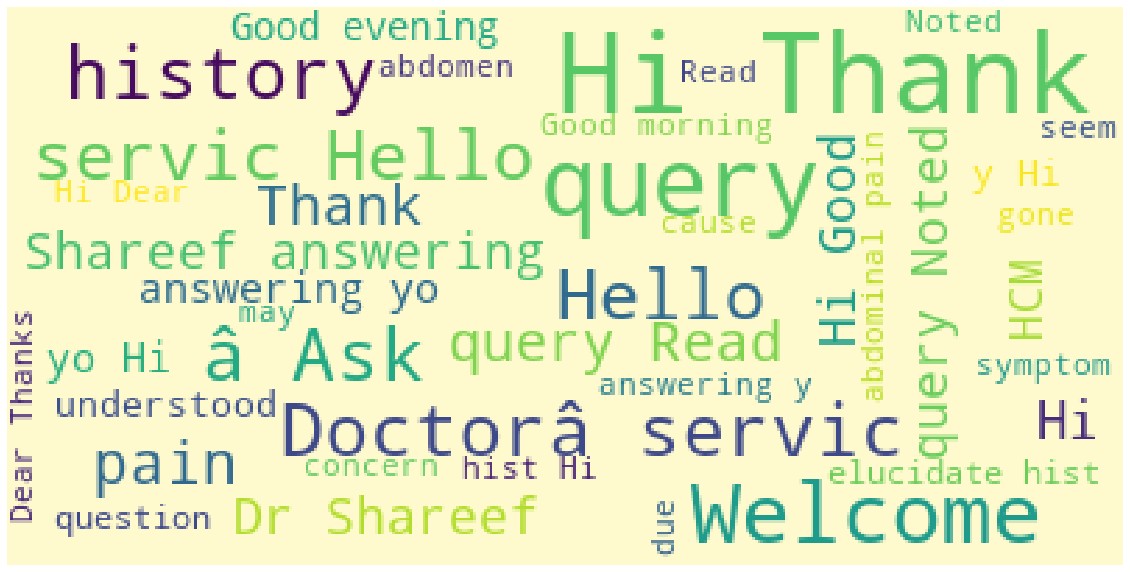

In [333]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='lemonchiffon', stopwords=stopwords,max_words=40, max_font_size=40, random_state=42)

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud.generate(str(df['Doctor_Dialogue'])))
plt.axis('off')
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['patient_dialogue_POS_removed'].str.replace('-PRON-', '')

In [295]:
#Function to find the top n-grams

def top_n_grams(corpus, top, n):
    vec = CountVectorizer(ngram_range=(n,n), stop_words='english')
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    freq = pd.Series(sum_words.tolist()[0], index=vec.get_feature_names())
    freq = freq.sort_values(ascending=False).head(top)
    return freq

In [311]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = top_n_grams(df["patient_dialogue_clean_no_stopwords"], 30, 1)

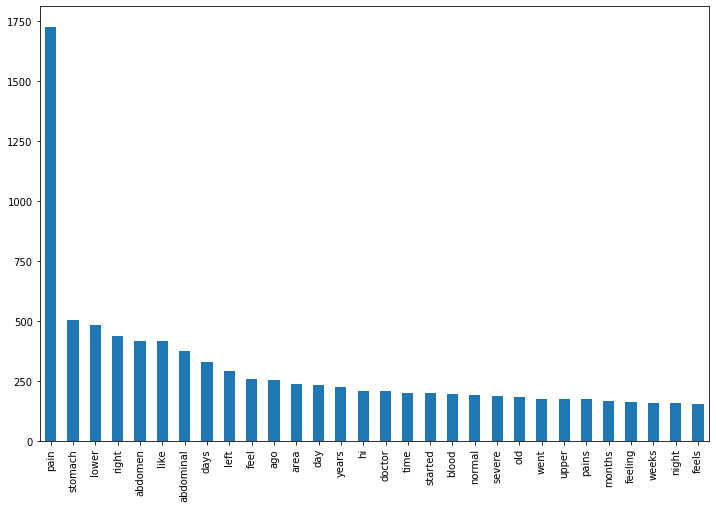

In [313]:
#Print the top 10 words in the unigram frequency
plt.figure(figsize=(12,8))
unigrams.head(30).plot.bar()
plt.show()

In [335]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = top_n_grams(df["doctor_dialogue_clean"], 30, 2)

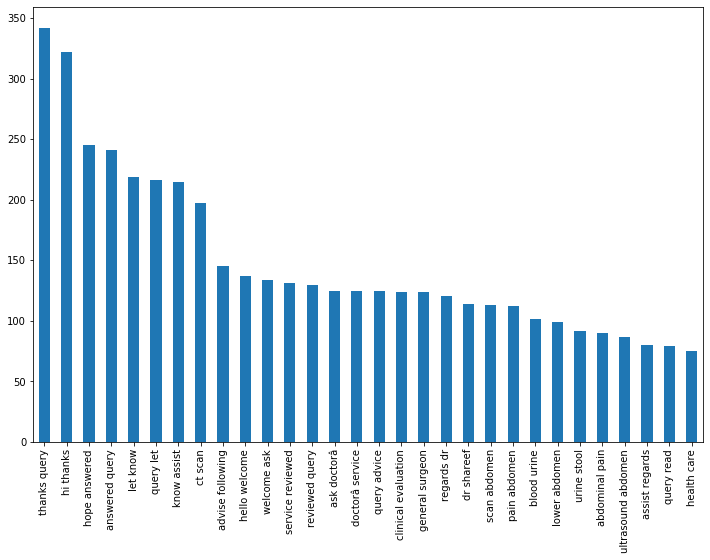

In [336]:
#Print the top 10 words in the bigram frequency
plt.figure(figsize=(12,8))
bigrams.head(30).plot.bar()
plt.show()

In [ ]:
from tqdm import tqdm
nouns = []

for review in tqdm(dial[:10000]):
    doc = model(review)
    for tok in doc:
        if tok.pos_=="NOUN" or tok.pos_=="PROPN":
            nouns.append(tok.text)

In [ ]:
pd.Series(nouns).value_counts().head(25)

In [ ]:
nwe_df = df_clean['patient_dialogue_lemma'][:100]

In [35]:
df.head()

Description  \
0  How can one treat intense pain in the stomach ...   
1  What causes abdominal pain similar to menstrua...   
2  Suggest remedies for recurrent abdominal pain ...   
3  What causes sensation of weird movements in th...   
4  Suggest remedies for recurrent pain in the abd...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   

                                     Doctor_Dialogue  
0  Hello,I don't think your ulcer is coming back ...  
1  Hello,Duphaston is a hormonal preparation and ...  
2  Hello,I read carefully your query and understa...  
3  Hi,There can be numerous clinical conditions t...  
4  Hello,Some females get more gastritis during m...

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (2, 2)
stop_words = "english"

# Extract candidate words/phrases
# count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Patient_Dialogue'][j]])
# candidates = count.get_feature_names()

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# doc_embedding = model.encode([df['Patient_Dialogue'][j]])
# candidate_embeddings = model.encode(candidates)

In [60]:
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [19]:

from sklearn.metrics.pairwise import cosine_similarity

top_n = 5
# distances = cosine_similarity(doc_embedding, candidate_embeddings)
# keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [25]:
test = ["abdominal pain, vomiting, acute leg cramps and arm cramps, pains in my back, pain in my chest, muscle weakness, twitching, depression, anxiety, racing and slow heart rates, frequent constipation, also I get bouts of diarrhea. I get jaundice too (i know what it is my 3 yr old daughter had it when born so i know the color and all that), and irregularly light colored stools (like light tan cardboard).  Also I am paler than average Asian.  Also I when I was pregnant I had diabetes even though I had a healthy diet prior to pregnancy and required insulin twice a day."]

In [22]:
test_df

Empty DataFrame
Columns: [patinet_notes, patient_dialogue_clean, patient_dialogue_clean_no_stopwords]
Index: []

In [49]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([test_df['patient_dialogue_clean_no_stopwords'][0]])
candidates = count.get_feature_names()

In [404]:
candidates

['abdominal pain',
 'acute hepatic',
 'alkaline phoshatase',
 'ask tests',
 'aspect liver',
 'attack pain',
 'cases rare',
 'causes acute',
 'causes mentioned',
 'clear thought',
 'consult gastroenterologist',
 'crisis lasting',
 'damage unknown',
 'days normal',
 'detailed reports',
 'details ask',
 'diagnosis treatment',
 'enzymes consult',
 'ercp help',
 'etiology recovers',
 'examine details',
 'exclusion causes',
 'fast like',
 'following investigations',
 'function tests',
 'gastroenterologist clear',
 'good modality',
 'help diagnosis',
 'hepatic damage',
 'hi thanks',
 'highly raised',
 'histological aspect',
 'history provided',
 'intense abdominal',
 'investigations attack',
 'iu normal',
 'lasting days',
 'like detailed',
 'liver exclusion',
 'liver function',
 'mentioned crisis',
 'modality possible',
 'mrcp ercp',
 'newer ultrasonographic',
 'normal cases',
 'normal histological',
 'pain highly',
 'pain mrcp',
 'pancreatic enzymes',
 'particularly alkaline',
 'phoshatase p

In [50]:
doc_embedding = model.encode([test_df.patient_dialogue_clean_no_stopwords[0]])
candidate_embeddings = model.encode(candidates)

In [406]:
candidate_embeddings

array([[-2.8330112e-01, -4.0163243e-01,  1.8411995e-01, ...,
        -2.7922428e-01,  6.9752407e-01, -4.1977125e-01],
       [-1.3765214e-01, -1.1415404e+00,  7.5068682e-01, ...,
        -4.0119973e-01,  1.7492257e-01, -4.6826550e-01],
       [-1.1651940e+00, -5.3102946e-01,  6.7823488e-01, ...,
        -3.1661731e-01,  1.9541597e-01,  6.3564640e-01],
       ...,
       [-2.8700656e-01,  3.8732868e-01, -6.7880206e-02, ...,
         6.0350031e-02,  3.5437413e-02, -5.0878304e-01],
       [-3.1966162e-01,  8.7911591e-02,  2.5628242e-01, ...,
        -7.3536289e-01, -9.5629541e-04, -7.8177077e-01],
       [-6.6251945e-01, -4.0284413e-01,  3.9608726e-01, ...,
        -2.1039259e-01,  9.1684371e-02, -5.0428843e-01]], dtype=float32)

In [405]:
doc_embedding

array([[-4.27455902e-01, -5.69272518e-01,  8.15099895e-01,
        -1.00342527e-01, -5.03990054e-01, -3.40835541e-01,
        -6.47802413e-01, -1.01949966e+00,  7.17873394e-01,
        -2.76126474e-01,  1.14372969e+00,  3.14349204e-01,
        -2.20012978e-01,  8.96183550e-01,  2.46429920e-01,
        -3.17392260e-01,  1.42084074e+00, -2.20898837e-01,
        -1.24613619e+00,  1.81897730e-01, -3.20720613e-01,
        -1.96031928e-02,  1.28379362e-02,  1.60632706e+00,
        -9.29161370e-01,  5.55394553e-02,  3.21677446e-01,
         2.16620043e-01,  4.74862158e-01,  3.12921256e-01,
         8.29729855e-01, -1.96579039e-01, -6.81443393e-01,
        -1.21265098e-01,  2.93379694e-01, -3.11835110e-01,
         1.65701166e-01,  9.39219594e-01,  1.04778373e+00,
        -1.05152071e+00, -8.26723278e-02, -2.09446594e-01,
         6.92773581e-01,  2.52369076e-01, -1.87838763e-01,
        -9.07511935e-02, -2.92895436e-01,  4.16318357e-01,
        -6.39648259e-01,  3.55763026e-02,  2.39696935e-0

In [51]:
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [52]:
keywords

['abdominal pain',
 'month terrible',
 'heartburn terrible',
 'doctor month',
 'pain heartburn']

In [396]:
distances.argsort()

array([[62, 15, 35, 29,  8, 66, 52, 54, 68, 65,  9, 55, 44, 21, 41, 13,
        51, 20, 73,  3, 32, 58, 30, 12, 23, 72, 64, 36, 63, 37, 22,  2,
        40, 71, 24, 42, 18, 16, 34, 26, 61, 49, 67, 31,  4, 14, 11, 45,
        17,  7, 53, 43, 27, 19, 60, 39, 48, 50, 10, 59, 57, 38, 25, 33,
         5, 56,  6, 70, 46, 69, 28,  1, 47,  0]], dtype=int64)

In [403]:
candidates[62]

'suggest following'

In [398]:
keywords

['ultrasonographic ultrasound',
 'hepatic damage',
 'acute hepatic',
 'pain mrcp',
 'abdominal pain']

In [29]:
keywords

['asian pregnant',
 'pain vomiting',
 'diarrhea jaundice',
 'diabetes healthy',
 'pregnant diabetes']

In [392]:
df.columns

Index(['Description', 'Patient_Dialogue', 'Doctor_Dialogue',
       'patient_dialogue_clean', 'doctor_dialogue_clean',
       'patient_dialogue_clean_lemma', 'patient_dialogue_clean_no_stopwords'],
      dtype='object')

In [393]:
df['patient_dialogue_clean'][0]

'Hi I m  I am ulcer patient  I did my endoscopy last yr in July and took medication till Feb after that I left the medicine and started taking DGL and probiotic for a month after that I did endoscopy again and found out that only superficial scars are left   but after endoscopy I really felt great pain the stomach again and mild pain after few days my doc told me not to take high protein diets but I ignored and took it and now I sometimes feel Pricky feeling in my stomach  I m worried whether my ulcer is coming back'

In [204]:
j = 666

In [205]:
top_n = 5

In [206]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Patient_Dialogue'][j]])
candidates = count.get_feature_names()

In [207]:
doc_embedding = model.encode([df['Patient_Dialogue'][j]])
candidate_embeddings = model.encode(candidates)

In [208]:
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [209]:
keywords

['tubrculosis stomach',
 'stomach paining',
 'intestinal tubrculosis',
 'tuberculosis soo',
 'test tuberculosis']

In [210]:
df['Patient_Dialogue'][j]

"Hiii... can u please tell me the tests done for abdominal or intestinal tubrculosis..??As my stomach is paining at right side.. so the doctor ask me to test it for tuberculosis..!! Soo.. can u pls help me.. and please tell me that is it communicable and can harm my family members..? For this what are the precautions i will have to take..!' I will be highly thankful to u!"

In [211]:
df['Doctor_Dialogue'][j]

'HelloAbdominal tuberculosis can be classified into the Tubercular mesenteric adenitis,intestinal tuberculosis, omental or tubercular peritonitis.The first investigation is blood test which can show increased ESR with raised lymphocytes count.Then an USG should be done to find out any enlarged and matted lymph node,thickening or adhesion of the intestinal wall or any collection of fluid.The next investigation may be CECT abdomen for better delineation of anatomic abnormality or if USG is doubtful. Sometimes there may be formation of cold abscess or mass,then aspiration of pus or USG guided biopsy of mass may be needed.The pus should be sent for test of tuberculosis.A test called Quantiferon gold test may also be advised for diagnosis.Tuberculosis is a communicable disease and mainly spread through droplets.Most communicable is pulmonary tuberculosis.Chances are very very less in abdominal tuberculosis if not associated with pulmonary TB.If there is only abdominal TB no specific precaut

In [212]:
top_n = 5

In [213]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Doctor_Dialogue'][j]])
candidates = count.get_feature_names()

In [214]:
doc_embedding = model.encode([df['Doctor_Dialogue'][j]])
candidate_embeddings = model.encode(candidates)

In [215]:
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [216]:
keywords

['diagnosis tuberculosis',
 'abdominal tuberculosis',
 'test tuberculosis',
 'helloabdominal tuberculosis',
 'blood test']

In [171]:
df['Doctor_Dialogue'][j]

'HelloAbdominal tuberculosis can be classified into the Tubercular mesenteric adenitis,intestinal tuberculosis, omental or tubercular peritonitis.The first investigation is blood test which can show increased ESR with raised lymphocytes count.Then an USG should be done to find out any enlarged and matted lymph node,thickening or adhesion of the intestinal wall or any collection of fluid.The next investigation may be CECT abdomen for better delineation of anatomic abnormality or if USG is doubtful. Sometimes there may be formation of cold abscess or mass,then aspiration of pus or USG guided biopsy of mass may be needed.The pus should be sent for test of tuberculosis.A test called Quantiferon gold test may also be advised for diagnosis.Tuberculosis is a communicable disease and mainly spread through droplets.Most communicable is pulmonary tuberculosis.Chances are very very less in abdominal tuberculosis if not associated with pulmonary TB.If there is only abdominal TB no specific precaut

In [41]:
import numpy as np
import itertools

def max_sum_sim(doc_embedding, word_embeddings, words, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings, 
                                            candidate_embeddings)

    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

In [138]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, 5, 10)

['porphiria intoxication',
 'biopsy saturnism',
 'transaminases completely',
 'days liver',
 'pain intense']

In [99]:
keywords

['manic depressive',
 'taking medicines',
 'relief pain',
 'pain diarrhoea',
 'pain spasm']

In [35]:
import numpy as np

def mmr(doc_embedding, word_embeddings, words, top_n, diversity):

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [53]:
a = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)

In [54]:
b = keywords

In [55]:
c = a + b

In [56]:
c

['pain heartburn',
 'doctor month',
 'goodmorning angela',
 'upper abdominal',
 'month terrible',
 'abdominal pain',
 'month terrible',
 'heartburn terrible',
 'doctor month',
 'pain heartburn']

In [57]:
c = list(set(c))

In [58]:
c

['doctor month',
 'upper abdominal',
 'goodmorning angela',
 'pain heartburn',
 'abdominal pain',
 'month terrible',
 'heartburn terrible']

In [22]:
desc[100]

'How can severe stomach cramps while having hernias be treated?'

In [45]:
len(dial)

106220

In [46]:
train_dialogues = dial[:1000]

In [48]:
train_dialogues

['Hi,I m XXXX,I am ulcer patient ,I did my endoscopy last yr in July and took medication till Feb after that I left the medicine and started taking DGL and probiotic for a month after that I did endoscopy again and found out that only superficial scars are left ..but after endoscopy I really felt great pain the stomach again and mild pain after few days.my doc told me not to take high protein diets.but I ignored and took it and now I sometimes feel Pricky feeling in my stomach .I m worried whether my ulcer is coming back',
 'I took the shot and started duphaston pills for 10 days, which r finished on the 7th of June, I got period pains right after I finished, but still no period. Does period pain mean it s coming? And du phantom only postponed it? Or I still could be pregnant even though I had those period pains? I just want to know if there is still hope in pregnancy, Thanks XXXX.',
 'Hi my name is XXXX. I have been having stomach pains over the past 5 years, not all the time tho it c

In [ ]:
keywords

In [ ]:
dial[60]

In [ ]:
df_clean['complaint_clean'][0]

In [ ]:
keywords

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (2, 2)
stop_words = "english"

# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([desc[10]])
candidates = count.get_feature_names()

In [60]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([desc[10]])
candidate_embeddings = model.encode(candidates)

In [61]:
from sklearn.metrics.pairwise import cosine_similarity

top_n = 5
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

In [63]:
desc[10]

'Is the gallbladder a cause for abdominal pain?'

In [ ]:
dial[100]

In [28]:
a

'Jam terrible pain stomach cramps.It 3 days nightmare.My gastroenterologist sad go emergency,but I cannot Waite hours seen. I already CT scan shows hernias. Can tell I help me? Thank'

In [217]:
df.head()

Description  \
0  How can one treat intense pain in the stomach ...   
1  What causes abdominal pain similar to menstrua...   
2  Suggest remedies for recurrent abdominal pain ...   
3  What causes sensation of weird movements in th...   
4  Suggest remedies for recurrent pain in the abd...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   

                                     Doctor_Dialogue  
0  Hello,I don't think your ulcer is coming back ...  
1  Hello,Duphaston is a hormonal preparation and ...  
2  Hello,I read carefully your query and understa...  
3  Hi,There can be numerous clinical conditions t...  
4  Hello,Some females get more gastritis during m...

In [218]:
df.shape[0]

5000

In [225]:
len(patients_keywords)

835

In [223]:
df.to_csv("data.csv")

In [55]:
df['Patient_Dialogue'][834]

'Hi.Thanks for your query. Read and understood the history. You have a problem for the last 4 weeks, that you have been suffering from Vomiting of White thick foamy stuff, and pain in abdomen; can not eat anything else other than bread. Noe, vomiting stopped but it looks from your history that you are constipated and still have pain in abdomen. This can be just due to constipation, blockage of the colon by fecoliths or cancer or any other pathology like stricture and so on. I would advise you the following:Investigations first as treatment can cause more problems if the diagnosis has not been done. -X-ray of the abdomen in standing position.-CT scan of the abdomen to understand the pathology. -Once clinical evaluation is done, cleaning of the colon by enema, oral peglac like osmotic cathartic and then colonoscopy.-Barium studies if no acute obstruction-Once the diagnosis has been made, the treatment can be planned according to the findings and can be a surgery. '

In [23]:
for j in list1:
    j= int(j)
    try:
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Patient_Dialogue'][j]])
        candidates = count.get_feature_names()
        doc_embedding = model.encode([df['Patient_Dialogue'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        patients_keywords.append(keywords)
        patients_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        patients_keywords.append([])
        patients_keywords_mmr.append([])
        continue

Errors Found in index
834


NameError: name 'patients_keywords' is not defined

In [54]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(df['Patient_Dialogue'][:2000])

In [59]:
bert_count_vectoriser = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words)

In [55]:
new_df = df[:2000]

In [ ]:
patients_keywords = []
patients_keywords_mmr = []

   
for j in range(0,2000):
    try:        
        candidates = count.get_feature_names()
        doc_embedding = model.encode([df['Patient_Dialogue'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        patients_keywords.append(keywords)
        patients_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        patients_keywords.append([])
        patients_keywords_mmr.append([])
        continue
new_df['Patients_keywords'] = patients_keywords
new_df['Patients_keywords_mmr'] = patients_keywords_mmr

    

In [38]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Patient_Dialogue'][1]])
candidates = count.get_feature_names()
doc_embedding = model.encode([df['Patient_Dialogue'][1]])
candidate_embeddings = model.encode(candidates)
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)

In [39]:
keywords_mmr

['postponed pregnant', 'pills 10', 'took shot', 'june got', 'duphaston pills']

In [40]:
keywords

['7th june', 'hope pregnancy', 'june got', 'pills 10', 'postponed pregnant']

In [33]:
patients_keywords

[['nausea vomiting',
  'cancer drs',
  'high cholesterol',
  'liver cancer',
  'diabetes high'],
 ['affects massage',
  'eye mri',
  'hr treatment',
  'aneurysm dr',
  'abdominal aneurysm'],
 ['35 years',
  '132 lbs',
  'cholesterol triglicerides',
  'latest results',
  'latest updates'],
 ['undergone hemithyrodictny',
  'mother undergone',
  'doctor mother',
  'cancer rt',
  'breast cancer'],
 ['blood stream',
  'gas impaired',
  'blood sugar',
  'impaired liver',
  'abdomen diabetic'],
 ['asian pregnant',
  'pain vomiting',
  'diarrhea jaundice',
  'diabetes healthy',
  'pregnant diabetes'],
 ['morning couch',
  'surgery year',
  'hypertrophic cardio',
  'cardio myopathy',
  'heart surgery'],
 ['taken naps',
  'hurts breaths',
  'abdominal pain',
  'morning hurts',
  'fever tired'],
 ['husband woke',
  'abdomen pain',
  'pain scrotum',
  'harder urinated',
  'urinated day']]

In [35]:
df['Patient_Dialogue'][3808]

'I am suffering from abdominal pain from past 3 months'

In [57]:
df['Patient_Dialogue'][834]

'Hi.Thanks for your query. Read and understood the history. You have a problem for the last 4 weeks, that you have been suffering from Vomiting of White thick foamy stuff, and pain in abdomen; can not eat anything else other than bread. Noe, vomiting stopped but it looks from your history that you are constipated and still have pain in abdomen. This can be just due to constipation, blockage of the colon by fecoliths or cancer or any other pathology like stricture and so on. I would advise you the following:Investigations first as treatment can cause more problems if the diagnosis has not been done. -X-ray of the abdomen in standing position.-CT scan of the abdomen to understand the pathology. -Once clinical evaluation is done, cleaning of the colon by enema, oral peglac like osmotic cathartic and then colonoscopy.-Barium studies if no acute obstruction-Once the diagnosis has been made, the treatment can be planned according to the findings and can be a surgery. '

In [ ]:
len(patients_keywords_mmr)

In [36]:
doctors_keywords = []
doctors_keywords_mmr = []
for j in range(0,df.shape[0]):
    try:
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([df['Doctor_Dialogue'][j]])
        candidates = count.get_feature_names()
        doc_embedding = model.encode([df['Doctor_Dialogue'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
        doctors_keywords.append(keywords)
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        doctors_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        patients_keywords.append([])
        patients_keywords_mmr.append([])
        continue
df['Doctors_keywords'] = doctors_keywords
df['Doctors_keywords_mmr'] = doctors_keywords_mmr

In [32]:
df['Doctor_Dialogue'][13]

'Hi, Noted your history of having pain in right lower abdomen and weakness in legs that lasted for 10 minutes.The commonest causes can be related to the following:Appendicitis Right ovarian and tubal problems.Colitis.Enteritis.These things can occur due to bacterial or viral infections.Hence I would advise you the following in such a situation:Consult a Doctor for an actual examination as this gives a lot of information on clinical basis.To be supported by investigations of blood, urine and stool.Ultrasonography of abdomen to be confirmed by CT scan of abdomen.Any problems with intestine cause electrolyte imbalance and thus gives weakness as you have had.Take plenty of fluids.Electrolyte solution may help with weakness.A course of an antibiotic and supportive medications may be needed as per the final findings. Hope I have answered your query. Let me know if I can assist you further. Regards, Dr. T Chandrakant, General Surgeon'

In [37]:
df.to_csv("data.csv")

In [47]:
doctor_keywords_merge = []
for i in range(0, len(doctors_keywords)):
    doctor_keywords_merge.append(list(set(doctors_keywords[i] + doctors_keywords_mmr[i])))


In [48]:
patient_keywords_merge = []
for i in range(0, len(doctors_keywords)):
    patient_keywords_merge.append(list(set(patients_keywords[i] + patients_keywords_mmr[i])))

In [52]:
doctor_keywords_merge[5]

['blood tests',
 'avoid oily',
 'tests blood',
 'gastroenterologist clear',
 'food rich',
 'answered query',
 'need diagnostic',
 'abdominal spasms',
 'needed doctor']

In [53]:
patient_keywords_merge[5]

['spasms uncontrol',
 'bowel pleasures',
 'gives spasms',
 'pleasures life',
 '24 worst',
 'regards relaxing',
 'thanks xxxx',
 'relaxing bowel',
 'movements like']

In [60]:
df = pd.read_csv("data.csv")

In [61]:
new_df = df[:1000]

In [62]:
new_df.head()

Unnamed: 0                                        Description  \
0           0  How can one treat intense pain in the stomach ...   
1           1  What causes abdominal pain similar to menstrua...   
2           2  Suggest remedies for recurrent abdominal pain ...   
3           3  What causes sensation of weird movements in th...   
4           4  Suggest remedies for recurrent pain in the abd...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   

                                     Doctor_Dialogue  \
0  Hello,I don't think your ulcer is coming back ...   
1  Hello,Duphaston is a hormonal preparation and ...   
2  Hello,I read carefully your query and understa...   
3  Hi,There can be numerous clinical conditions t...   
4  Hello,Some females get more gastritis during m...   

                                   Patients_keywords  \
0  ['dgl probiotic', 'took medication', 'pain sto...   
1  ['7th june', 'hope pregnancy', 'june got', 'pi...   
2  ['vacation went', 'went vacation', 'went hospi...   
3  ['tooktook pregnancy', 'pregnant tooktook', 's...   
4  ['like heartburn', 'pain increasing', 'heartbu...   

                               Patients_keywords_mmr  \
0  ['probiotic month', 'high protein', 'diets ign...   
1  ['postponed pregnant', 'pills 10', 'took shot'...   
2  ['hospital pains', 'went vacation', 'bowl spel...   
3  ['pregnant months', 'sharp pain', 'just want',...   
4  ['heartburn heartburn', 'making eat', '3600mg ...   

                                    Doctors_keywords  \
0  ['contact doctor', 'doctor advise', 'doctor ad...   
1  ['pregnancy 20', 'pregnancy suggest', 'chance ...   
2  ['rich diet', 'recommend drink', 'diet hope', ...   
3  ['abdomen pelvis', 'intestine colic', 'gastric...   
4  ['add gastritis', 'menstrual days', 'meals nsa...   

                                Doctors_keywords_mmr  
0  ['diet doctor', 'intense contact', 'jolanda ni...  
1  ['pregnancy test', 'week stopping', 'hope answ...  
2  ['probiotics recommend', 'rich diet', 'cause a...  
3  ['need ultrasound', 'anti spasmodic', 'pelvis ...  
4  ['females gastritis', 'syrup meals', 'days ant...

In [63]:
new_df.columns

Index(['Unnamed: 0', 'Description', 'Patient_Dialogue', 'Doctor_Dialogue',
       'Patients_keywords', 'Patients_keywords_mmr', 'Doctors_keywords',
       'Doctors_keywords_mmr'],
      dtype='object')

In [64]:
new_df.drop(columns="Unnamed: 0", inplace=True)

In [65]:
new_df.head()

Description  \
0  How can one treat intense pain in the stomach ...   
1  What causes abdominal pain similar to menstrua...   
2  Suggest remedies for recurrent abdominal pain ...   
3  What causes sensation of weird movements in th...   
4  Suggest remedies for recurrent pain in the abd...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   

                                     Doctor_Dialogue  \
0  Hello,I don't think your ulcer is coming back ...   
1  Hello,Duphaston is a hormonal preparation and ...   
2  Hello,I read carefully your query and understa...   
3  Hi,There can be numerous clinical conditions t...   
4  Hello,Some females get more gastritis during m...   

                                   Patients_keywords  \
0  ['dgl probiotic', 'took medication', 'pain sto...   
1  ['7th june', 'hope pregnancy', 'june got', 'pi...   
2  ['vacation went', 'went vacation', 'went hospi...   
3  ['tooktook pregnancy', 'pregnant tooktook', 's...   
4  ['like heartburn', 'pain increasing', 'heartbu...   

                               Patients_keywords_mmr  \
0  ['probiotic month', 'high protein', 'diets ign...   
1  ['postponed pregnant', 'pills 10', 'took shot'...   
2  ['hospital pains', 'went vacation', 'bowl spel...   
3  ['pregnant months', 'sharp pain', 'just want',...   
4  ['heartburn heartburn', 'making eat', '3600mg ...   

                                    Doctors_keywords  \
0  ['contact doctor', 'doctor advise', 'doctor ad...   
1  ['pregnancy 20', 'pregnancy suggest', 'chance ...   
2  ['rich diet', 'recommend drink', 'diet hope', ...   
3  ['abdomen pelvis', 'intestine colic', 'gastric...   
4  ['add gastritis', 'menstrual days', 'meals nsa...   

                                Doctors_keywords_mmr  
0  ['diet doctor', 'intense contact', 'jolanda ni...  
1  ['pregnancy test', 'week stopping', 'hope answ...  
2  ['probiotics recommend', 'rich diet', 'cause a...  
3  ['need ultrasound', 'anti spasmodic', 'pelvis ...  
4  ['females gastritis', 'syrup meals', 'days ant...

In [66]:
new_df["Patient_Dialogue_lemma"] = new_df["Patient_Dialogue"].apply(lemmatize_text)

In [85]:
new_df["Doctor_Dialogue_lemma"] = new_df["Doctor_Dialogue"].apply(lemmatize_text)

In [67]:
new_df.head()

Description  \
0  How can one treat intense pain in the stomach ...   
1  What causes abdominal pain similar to menstrua...   
2  Suggest remedies for recurrent abdominal pain ...   
3  What causes sensation of weird movements in th...   
4  Suggest remedies for recurrent pain in the abd...   

                                    Patient_Dialogue  \
0  Hi,I m XXXX,I am ulcer patient ,I did my endos...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is XXXX. I have been having stomach...   
3  Hi, my name is XXXX I m a 19year old girl and ...   
4  Hi! My name is XXXX and I used to take an insa...   

                                     Doctor_Dialogue  \
0  Hello,I don't think your ulcer is coming back ...   
1  Hello,Duphaston is a hormonal preparation and ...   
2  Hello,I read carefully your query and understa...   
3  Hi,There can be numerous clinical conditions t...   
4  Hello,Some females get more gastritis during m...   

                                   Patients_keywords  \
0  ['dgl probiotic', 'took medication', 'pain sto...   
1  ['7th june', 'hope pregnancy', 'june got', 'pi...   
2  ['vacation went', 'went vacation', 'went hospi...   
3  ['tooktook pregnancy', 'pregnant tooktook', 's...   
4  ['like heartburn', 'pain increasing', 'heartbu...   

                               Patients_keywords_mmr  \
0  ['probiotic month', 'high protein', 'diets ign...   
1  ['postponed pregnant', 'pills 10', 'took shot'...   
2  ['hospital pains', 'went vacation', 'bowl spel...   
3  ['pregnant months', 'sharp pain', 'just want',...   
4  ['heartburn heartburn', 'making eat', '3600mg ...   

                                    Doctors_keywords  \
0  ['contact doctor', 'doctor advise', 'doctor ad...   
1  ['pregnancy 20', 'pregnancy suggest', 'chance ...   
2  ['rich diet', 'recommend drink', 'diet hope', ...   
3  ['abdomen pelvis', 'intestine colic', 'gastric...   
4  ['add gastritis', 'menstrual days', 'meals nsa...   

                                Doctors_keywords_mmr  \
0  ['diet doctor', 'intense contact', 'jolanda ni...   
1  ['pregnancy test', 'week stopping', 'hope answ...   
2  ['probiotics recommend', 'rich diet', 'cause a...   
3  ['need ultrasound', 'anti spasmodic', 'pelvis ...   
4  ['females gastritis', 'syrup meals', 'days ant...   

                              Patient_Dialogue_lemma  
0  Hi I m XXXX I am ulcer patient  I did my endos...  
1  I took the shot and started duphaston pills fo...  
2  Hi my name is XXXX  I have been having stomach...  
3  Hi  my name is XXXX I m a  old girl and I keep...  
4  Hi  My name is XXXX and I used to take an insa...

In [68]:
# new_df["Patient_Dialogue_POS_removed"] = new_df["Patient_Dialogue_lemma"].apply(get_singular_nouns)

In [69]:
# new_df.head()

In [70]:
new_df['Patient_Dialogue_clean'] = new_df['Patient_Dialogue_lemma'].str.replace('XXXX','')

In [86]:
new_df['Doctor_Dialogue_clean'] = new_df['Doctor_Dialogue_lemma'].str.replace('XXXX','')

In [87]:
new_df.to_csv("data2.csv")

In [71]:
clean_df = new_df[['Patient_Dialogue_clean']]

In [88]:
clean_df['Doctor_Dialogue_clean'] = new_df[['Doctor_Dialogue_clean']]

In [89]:
clean_df.head()

Patient_Dialogue_clean  \
0  Hi I m  I am ulcer patient  I did my endoscopy...   
1  I took the shot and started duphaston pills fo...   
2  Hi my name is   I have been having stomach pai...   
3  Hi  my name is  I m a  old girl and I keep get...   
4  Hi  My name is  and I used to take an insane a...   

                                   Patients_keywords  \
0  [dgl probiotic, pain stomach, took medication,...   
1  [pills days, june got, hope pregnancy, finishe...   
2  [vacation went, went hospital, went vacation, ...   
3  [weird pain, pregnant tooktook, thought pregna...   
4  [pain increasing, like heartburn, heartburn fe...   

                               Patients_keywords_mmr  \
0  [probiotic month, high protein, diets ignored,...   
1  [postponed pregnant, took shot, finished june,...   
2  [hospital pains, went vacation, bowl spelled, ...   
3  [pregnancy test, sharp pain, months gone, time...   
4  [heartburn heartburn, making eat, days day, do...   

                          Patients_keywords_combined  \
0  [ulcer patient, high protein, diets ignored, t...   
1  [took shot, finished june, june got, duphaston...   
2  [vacation went, strong laxative, past years, s...   
3  [pregnant tooktook, time sex, months gone, pre...   
4  [days day, heartburn feels, pain increasing, h...   

                               Doctor_Dialogue_clean  
0  Hello I don t think your ulcer is coming back ...  
1  Hello Duphaston is a hormonal preparation and ...  
2  Hello I read carefully your query and understa...  
3  Hi There can be numerous clinical conditions t...  
4  Hello Some females get more gastritis during m...

In [407]:
clean_df.Patients_keywords[0]

['dgl probiotic',
 'pain stomach',
 'took medication',
 'ulcer patient',
 'probiotic month']

In [408]:
clean_df.Patients_keywords_mmr[0]

['probiotic month',
 'high protein',
 'diets ignored',
 'ulcer patient',
 'taking dgl']

In [425]:
clean_df.Patients_keywords_combined[0]

['ulcer patient',
 'high protein',
 'diets ignored',
 'took medication',
 'probiotic month',
 'dgl probiotic',
 'taking dgl',
 'pain stomach']

In [73]:
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([clean_df['Patient_Dialogue_clean'][5]])
candidates = count.get_feature_names()

In [74]:
candidates

['bowel pleasures',
 'gives spasms',
 'gut gives',
 'help thoughts',
 'life thanks',
 'like pulsating',
 'like regards',
 'movements like',
 'pleasures life',
 'pulsating worst',
 'regards relaxing',
 'relaxing bowel',
 'spasms uncontrol',
 'stressed like',
 'thoughts gut',
 'uncontrol movements',
 'worst stressed']

In [75]:
doc_embedding = model.encode([clean_df['Patient_Dialogue_clean'][5]])

In [76]:
candidate_embeddings = model.encode(candidates)

In [77]:
candidates = count.get_feature_names()
doc_embedding = model.encode([clean_df['Patient_Dialogue_clean'][5]])
candidate_embeddings = model.encode(candidates)
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)

In [78]:
keywords

['spasms uncontrol',
 'regards relaxing',
 'bowel pleasures',
 'gives spasms',
 'relaxing bowel']

In [79]:
keywords

['spasms uncontrol',
 'regards relaxing',
 'bowel pleasures',
 'gives spasms',
 'relaxing bowel']

In [80]:
clean_df['Patient_Dialogue_clean'][5]

'Please can you help me with thoughts about its  Where my gut gives out spasms and  Uncontrol movements like pulsating    It seems  Worst when stressed I would like something that regards relaxing the bowel to get some more pleasures in life  Many thanks  '

In [81]:
patients_keywords = []
patients_keywords_mmr = []

   
for j in range(0,1000):
    try:           
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([clean_df['Patient_Dialogue_clean'][j]])
        candidates = count.get_feature_names()
        doc_embedding = model.encode([clean_df['Patient_Dialogue_clean'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        patients_keywords.append(keywords)
        patients_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        patients_keywords.append([])
        patients_keywords_mmr.append([])
        
clean_df['Patients_keywords'] = patients_keywords
clean_df['Patients_keywords_mmr'] = patients_keywords_mmr

In [90]:
doctors_keywords = []
doctors_keywords_mmr = []

   
for j in range(0,1000):
    try:           
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([clean_df['Doctor_Dialogue_clean'][j]])
        candidates = count.get_feature_names()
        doc_embedding = model.encode([clean_df['Doctor_Dialogue_clean'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        doctors_keywords.append(keywords)
        doctors_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        doctors_keywords.append([])
        doctors_keywords.append([])
        
clean_df['Doctors_keywords'] = doctors_keywords
clean_df['Doctors_keywords_mmr'] = doctors_keywords_mmr

ValueError: Length of values does not match length of index

In [91]:
doctors_keywords = []
doctors_keywords_mmr = []

   
for j in range(0,1000):
    try:           
        count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([clean_df['Doctor_Dialogue_clean'][j]])
        candidates = count.get_feature_names()
        doc_embedding = model.encode([clean_df['Doctor_Dialogue_clean'][j]])
        candidate_embeddings = model.encode(candidates)
        distances = cosine_similarity(doc_embedding, candidate_embeddings)
        keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]        
        keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
        doctors_keywords.append(keywords)
        doctors_keywords_mmr.append(keywords_mmr)
    except:
        print("Errors Found in index")
        print(j)
        doctors_keywords.append([])
        doctors_keywords_mmr.append([])
        
clean_df['Doctors_keywords'] = doctors_keywords
clean_df['Doctors_keywords_mmr'] = doctors_keywords_mmr

In [54]:
clean_df['Patient_Dialogue_clean'][5]

'gut something bowel life '

In [82]:
patient_keywords_merge = []
for i in range(0, len(patients_keywords)):
    patient_keywords_merge.append(list(set(patients_keywords[i] + patients_keywords_mmr[i])))

In [92]:
doctor_keywords_merge = []
for i in range(0, len(doctors_keywords)):
    doctor_keywords_merge.append(list(set(doctors_keywords[i] + doctors_keywords_mmr[i])))

In [83]:
clean_df['Patients_keywords_combined'] = patient_keywords_merge

In [93]:
clean_df['Doctors_keywords_combined'] = doctor_keywords_merge

In [255]:
clean_df

Patient_Dialogue_clean  \
0    Hi I m  I am ulcer patient  I did my endoscopy...   
1    I took the shot and started duphaston pills fo...   
2    Hi my name is   I have been having stomach pai...   
3    Hi  my name is  I m a  old girl and I keep get...   
4    Hi  My name is  and I used to take an insane a...   
5    Please can you help me with thoughts about its...   
6    I have a sharp pain at the front of my hip at ...   
7    I have of sever abdominal pain  I work swing s...   
8    I woke up this morning feeling fine  I felt th...   
9    Hi  my name is   I am  years old  I have just ...   
10   Hello  I had some concerning symptoms today th...   
11   Friday morning I woke up with a terrible pain ...   
12   Hi Severe Discomfort slight pain on far right ...   
13   I ve had what I thought was the flu but along ...   
14   I have a friend experiencing severe right hand...   
15   Hi About a week ago I had extreme pain in my c...   
16   I was being dumb and did some meth over the we...   
17   i have been feeling pains on the lower right s...   
18   Hi  I am a  year old female  I have been have ...   
19   Hello  I am a  year old female and have been g...   
20   year old female   Developed left mid abdominal...   
21   I have had a lot of pain in the upper abdomen ...   
22   I m having stomach pain that hasn t gone away ...   
23   I took  tabs of phenazopyridine hydrochloride ...   
24   Good afternoon  I am a RN but I have a palpabl...   
25   On Tuesday  I had abdominal pain which was  at...   
26   Hi I am having abdominal pain from my right si...   
27   I ve been having abdominal pain first on my ri...   
28   My symptoms are abdominal pain  bloating  tire...   
29   I have side pain  abdominal pain  smelly urine...   
30   Iâ  ve been having severe upper left abdominal...   
31   My daughter has had bad abdominal pain for  we...   
32   My son is experiencing severe abdominal pain a...   
33   My  year old daughter is suffering from abdomi...   
34   My husband has been having lower abdominal pai...   
35   For several weeks I have experienced upper abd...   
36   I am having severe stomach pain that wraps aro...   
37   Hi my girl friend get stomach craps and  diarr...   
38   My son is  old for the past few days he is not...   
39   I have a dull pain in right lower abdomen off ...   
40   I have problem with stomach discomfort  when I...   
41   I m pretty good at identifying my body s organ...   
42   Hi  I have a constant pain in my lower abdomen...   
43   Iâ  ve just saw my doctor about an on and off ...   
44   My husband is feeling stomach pain after eatin...   
45   My grandson is   About every  weeks he gets st...   
46   Iâ  m having sharp quick stabbing like pains i...   
47   I am having pain in lower right side of the ab...   
48   I have a steady pain in my upper left abdomen ...   
49   Hello   I am having fairly acute pain above my...   
50   Each month  for about a year or more now  I ex...   
51   i have moderate pain in my upper left abdomen ...   
52   Hi  I have a sharp pain in my upper abdomen  l...   
53   I have had an uncomfortable pain sometimes sta...   
54   My wife has been experiencing upper left side ...   
55   Hi my name is preet i am suffering from upper ...   
56   I am having awful pain in my stomach  Itâ  s m...   
57   I have a pain in my upper left side of my stom...   
58   Goodmorning i am angela i am  years old for a ...   
59   I suffer from severe pain and colic in the sto...   
60   I have swollen abdomen around belly button  ab...   
61   Since last Friday  everytime I eat a full meal...   
62   Hi my wife  y old  she have  child and her fac...   
63   I had lower stomach pain  nights ago bad till ...   
64   I am having pain in my lower abdominal area   ...   
65   Woke up this morning with severe pain in lower...   
66   hello I have been having lower abd pain x  day...   
67   yes i was diagnosed with diverticulosis  yrs a...   
68   I have been lower abdomin

In [423]:
patient_keywords_merge[161]

['sales count',
 'stomach pain',
 'worried cancer',
 'eat hurts',
 'strong family',
 'infection extremely',
 'pain stomach',
 'white blood',
 'stomach kills']

In [94]:
doctor_keywords_merge

[['doctor advise',
  'doctor advised',
  'intense contact',
  'diet doctor',
  'advise hope',
  'jolanda nikolla',
  'careful diet',
  'contact doctor'],
 ['pregnancy suggest',
  'deficiency progesterone',
  'pregnancy hope',
  'pregnancy test',
  'week stopping',
  'suggest pregnancy',
  'hope answered',
  'common pain',
  'chance pregnancy'],
 ['eat fiber',
  'probiotics recommend',
  'daily probiotics',
  'diet hope',
  'rich diet',
  'use daily',
  'recommend drink',
  'cause ablocked'],
 ['pelvis precise',
  'need ultrasound',
  'prescription gp',
  'gastric upset',
  'anti spasmodic',
  'intestine colic',
  'later discuss',
  'ultrasound abdomen',
  'abdomen pelvis'],
 ['experience painful',
  'menstrual days',
  'days antacids',
  'nsaids add',
  'syrup meals',
  'females gastritis',
  'meals nsaids',
  'add gastritis',
  'gastritis menstrual'],
 ['needed doctor',
  'abdominal spasms',
  'tests blood',
  'gastroenterologist clear',
  'need diagnostic',
  'food rich',
  'oily foo

In [61]:
medical_dataset = pd.read_csv("drugsComTrain_raw.csv")

In [292]:
medical_dataset1['condition'].value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [137]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 9999)

In [127]:
medical_dataset.shape

(161297, 7)

In [62]:
medical_dataset.dropna(inplace=True)

In [129]:
medical_dataset.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

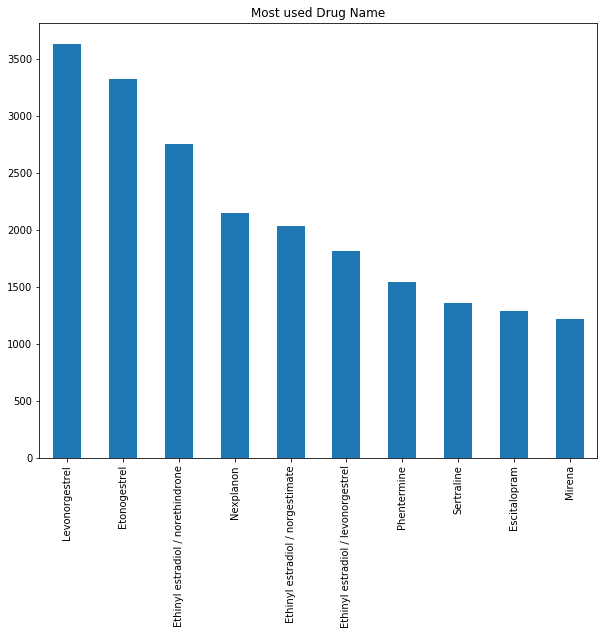

In [343]:
plt.figure(figsize=(10,8))
plt.title("Most used Drug Name")
medical_dataset['drugName'].value_counts()[:10].plot.bar()

In [345]:
medical_dataset['drugName'].value_counts()[:10]

Levonorgestrel                        3631
Etonogestrel                          3321
Ethinyl estradiol / norethindrone     2750
Nexplanon                             2149
Ethinyl estradiol / norgestimate      2033
Ethinyl estradiol / levonorgestrel    1809
Phentermine                           1538
Sertraline                            1353
Escitalopram                          1287
Mirena                                1219
Name: drugName, dtype: int64

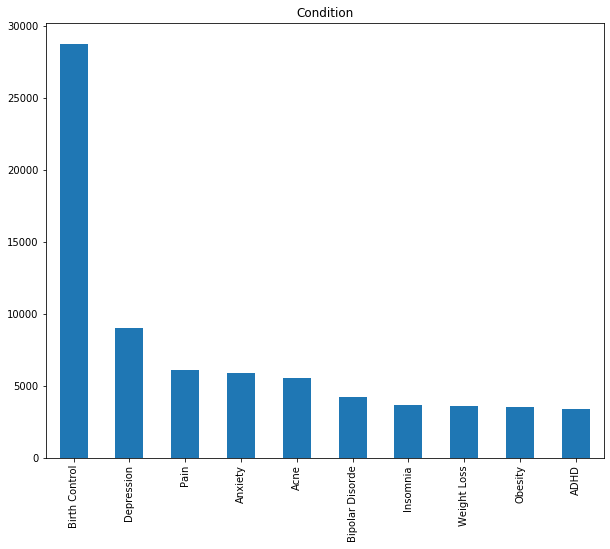

In [344]:
plt.figure(figsize=(10,8))
plt.title("Condition")
medical_dataset['condition'].value_counts()[:10].plot.bar()

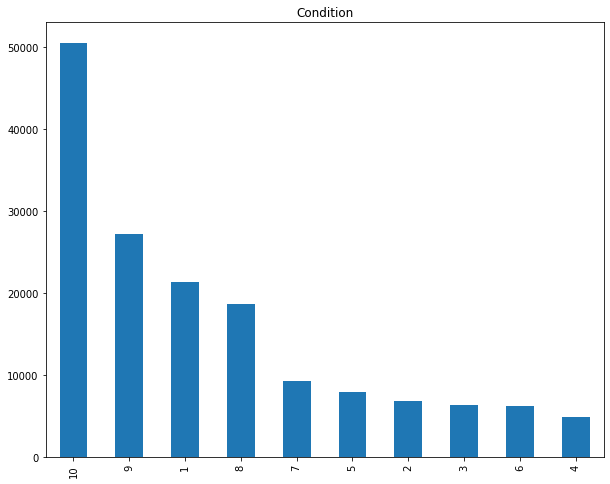

In [369]:
plt.figure(figsize=(10,8))
plt.title("Condition")
medical_dataset['rating'].value_counts()[:10].plot.bar()

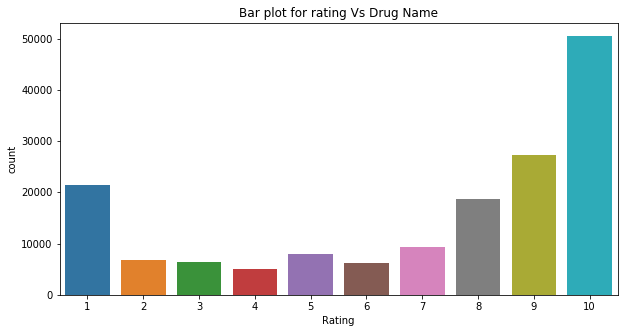

In [388]:
plt.figure(figsize=[10,5])
sns.countplot(medical_dataset['rating'])
plt.xlabel('Rating')
plt.title('Bar plot for rating Vs Drug Name')
plt.show()

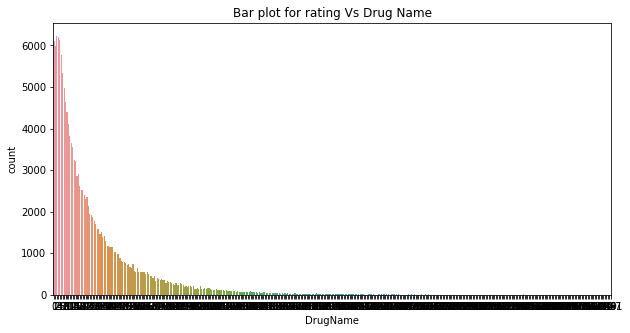

In [387]:
plt.figure(figsize=[10,5])
sns.countplot(medical_dataset['usefulCount'])
plt.xlabel('DrugName')
plt.title('Bar plot for rating Vs Drug Name')
plt.show()

In [371]:
medical_dataset_rating =medical_dataset.sort_values(by='rating', ascending=False)

In [372]:
medical_dataset_rating

index                         drugName  \
33181    33583                     Aripiprazole   
41215    41707                        Augmentin   
101942  103111                         Voltaren   
101939  103108                   Levonorgestrel   
101938  103107                       Gabapentin   
...        ...                              ...   
140827  142442                           Prozac   
98323    99453                      Bepotastine   
140825  142440                      Lifitegrast   
80104    81045  Sulfamethoxazole / trimethoprim   
66363    67157                          Abilify   

                             condition  rating  usefulCount  condition_is_spam  
33181                       Depression      10          141              False  
41215                     Strep Throat      10           38              False  
101942                            Pain      10           62              False  
101939         Emergency Contraception      10           21              False  
101938                        Insomnia      10           37              False  
...                                ...     ...          ...                ...  
140827  Premenstrual Dysphoric Disorde       1           15              False  
98323         Conjunctivitis, Allergic       1            7              False  
140825                 Dry Eye Disease       1            5              False  
80104              Bacterial Infection       1           10              False  
66363                       Depression       1           19              False  

[159498 rows x 6 columns]

In [130]:
medical_dataset.drop(columns=["uniqueID", 'date','review'], inplace=True)

In [63]:
medical_dataset['condition_is_spam'] = list(map(lambda x: '</span>' in x, medical_dataset['condition']))

In [64]:
medical_dataset['condition_is_spam'].value_counts()

False    159498
True        900
Name: condition_is_spam, dtype: int64

In [65]:
medical_dataset['condition_is_spam'].value_counts()

False    159498
True        900
Name: condition_is_spam, dtype: int64

In [66]:
medical_dataset = medical_dataset[medical_dataset['condition_is_spam']==False]
medical_dataset.reset_index(inplace=True)

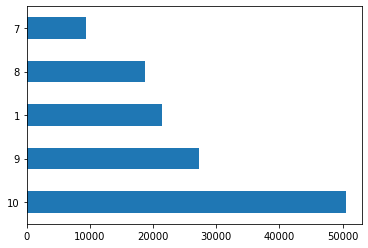

In [340]:
medical_dataset['rating'].value_counts()[:5].plot.barh()

In [138]:
medical_dataset['usefulCount'].value_counts()

2       6228
3       6214
4       6123
0       6113
1       5978
5       5769
6       5333
7       4985
8       4644
9       4405
10      4110
11      3819
12      3660
13      3544
14      3245
15      3223
17      2915
16      2860
18      2625
19      2528
20      2524
21      2397
23      2351
22      2303
24      2133
25      1935
26      1930
27      1875
28      1771
29      1714
31      1584
30      1574
33      1502
32      1472
35      1409
34      1398
36      1283
37      1183
38      1175
39      1151
40      1147
41      1142
43      1040
42      1033
45       980
44       975
46       889
47       815
48       790
49       783
50       754
55       751
52       735
51       720
53       658
54       654
58       634
56       563
61       558
59       551
57       547
62       547
63       542
60       540
65       537
66       507
64       493
67       464
68       450
70       444
69       416
72       414
73       387
75       386
74       358
76       355
77       349

In [67]:
medical_dataset_clean = medical_dataset[medical_dataset['usefulCount']>100]

In [68]:
medical_dataset_clean.shape

(6895, 9)

In [69]:
medical_dataset_clean = medical_dataset_clean[medical_dataset_clean['rating']>=6]
medical_dataset_clean.reset_index(inplace=True)

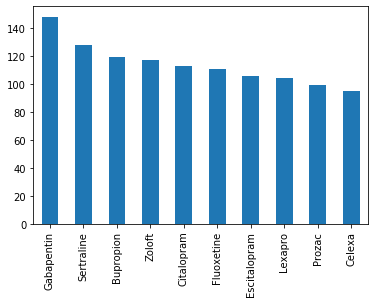

In [389]:
medical_dataset_clean['drugName'].value_counts()[:10].plot.bar()

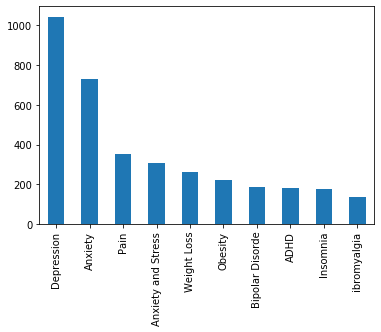

In [390]:
medical_dataset_clean['condition'].value_counts()[:10].plot.bar()

In [70]:
medical_dataset_clean.drop(columns=['level_0', 'index', 'condition_is_spam'], inplace=True)

In [71]:
medical_dataset_clean[['drugName', 'condition']]

drugName                     condition
0                     Guanfacine                          ADHD
1                  Buprenorphine                          Pain
2                     Effexor XR                    Depression
3     Phillips' Milk of Magnesia                  Constipation
4                         Cialis  Benign Prostatic Hyperplasia
...                          ...                           ...
6411                      Xeloda     Breast Cancer, Metastatic
6412                 Phentermine                   Weight Loss
6413                    Zolpidem                      Insomnia
6414                     Campral            Alcohol Dependence
6415                Lubiprostone         Constipation, Chronic

[6416 rows x 2 columns]

In [112]:
cvec = CountVectorizer().fit(medical_dataset_clean['condition'])

In [74]:
lr_count_vectoriser = cvec

In [113]:
X_frame_transform = cvec.transform(medical_dataset_clean['condition'])

In [114]:
X_frame_transform

<6416x282 sparse matrix of type '<class 'numpy.int64'>'
	with 10719 stored elements in Compressed Sparse Row format>

In [115]:
y = medical_dataset_clean['drugName']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_frame_transform, y, test_size=0.30, random_state=42)

In [117]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [121]:
y_pred = lr.predict(X_test)

In [120]:
X_test = cvec.transform(["ADHD"])

In [118]:
print("Accuracy " , accuracy_score(y_test, y_pred))

Accuracy  0.14857142857142858


In [82]:
def join_string(text):
    return (", ").join(text)

In [83]:
medical_dataset_clean_new=medical_dataset_clean.groupby(medical_dataset_clean['condition']).aggregate({'drugName':join_string})

In [ ]:
medical_dataset_clean_new.head(10)

In [415]:
medical_dataset_clean_new.to_csv("groupby_medicine_dataset.csv")

In [197]:
dict1 = {}
for i in range(0,len(medical_dataset_clean_new)):   
    dict1[list(medical_dataset_clean_new.index)[i]] = medical_dataset_clean_new['drugName'][i]

In [172]:
dict1

{'ADHD': 'Guanfacine, Methylphenidate, Wellbutrin SR, Desoxyn, Amphetamine / dextroamphetamine, Kapvay, Intuniv, Bupropion, Strattera, Concerta, Strattera, Intuniv, Intuniv, Concerta, Wellbutrin, Modafinil, Amphetamine / dextroamphetamine, Omega-3 polyunsaturated fatty acids, Vyvanse, Methamphetamine, Metadate CD, Vyvanse, Lisdexamfetamine, Adderall, Lisdexamfetamine, Atomoxetine, Methylphenidate, Guanfacine, Guanfacine, Methylphenidate, Guanfacine, Vyvanse, Amphetamine / dextroamphetamine, Desoxyn, Methamphetamine, Intuniv, Desoxyn, Adderall, Methamphetamine, Ritalin, Bupropion, Bupropion, Ritalin, Strattera, Vyvanse, Atomoxetine, Atomoxetine, Dexedrine, Strattera, Clonidine, Methylphenidate, Adderall, Lisdexamfetamine, Guanfacine, Dexmethylphenidate, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Guanfacine, Methylphenidate, Adderall XR, Guanfacine, Dextroamphetamine, Kapvay, Desoxyn, Intuniv, Amphetamine / dextroamphetamine, Addera

In [198]:
y_pred = lr.predict(X_frame_transform)

In [199]:
y_pred = (list(y_pred))

In [200]:
medical_dataset_clean_new.reset_index(inplace=True)

In [233]:
count = 0
wrong_list = []
for i in range(0, len(medical_dataset_clean)):
    print(medical_dataset_clean['condition'][i])
    if y_pred[i] in dict1[medical_dataset_clean['condition'][i]].split(', '):
        print(count)
        count +=1
    else:
        pass
#             wrong_list.append([y_pred1[i], dict1[medical_dataset_clean_new['condition'][i]]])
#     except:
#         print('error')

ADHD
0
Pain
1
Depression
2
Constipation
3
Benign Prostatic Hyperplasia
4
Atrophic Vaginitis
5
Depression
6
Birth Control
7
Major Depressive Disorde
8
Birth Control
9
Abnormal Uterine Bleeding
10
Pain
11
Pain
12
Depression
13
Irritable Bowel Syndrome
14
Hypothyroidism, After Thyroid Removal
15
Generalized Anxiety Disorde
16
Onychomycosis, Toenail
17
Anxiety and Stress
18
Anxiety
19
Autism
20
Depression
21
Abnormal Uterine Bleeding
22
Anxiety
23
Angina Pectoris Prophylaxis
Panic Disorde
24
ADHD
25
Prostatitis
Anxiety
26
Pain
27
Major Depressive Disorde
28
Weight Loss
29
Vaginal Yeast Infection
30
Depression
31
Anxiety and Stress
32
Panic Disorde
33
Pain
34
Depression
35
Anxiety
36
Insomnia
37
Pain
38
Depression
39
Skin or Soft Tissue Infection
40
Depression
41
Pain
42
Depression
43
Atrophic Vaginitis
44
Overactive Bladde
45
ADHD
46
Depression
47
Weight Loss
48
Rheumatoid Arthritis
49
Acne
50
Anxiety
51
Anxiety
52
Depression
53
Insomnia
54
Pain
55
Depression
56
Insomnia
57
Insomnia
58
Hot

533
Pain
534
Anxiety
535
Depression
536
Bipolar Disorde
537
Birth Control
538
Irritable Bowel Syndrome
539
Osteoarthritis
540
Anxiety
541
Anxiety
542
Diabetes, Type 2
543
Smoking Cessation
544
Rheumatoid Arthritis
545
Erectile Dysfunction
546
Depression
547
Migraine Prevention
548
Anxiety and Stress
549
Depression
550
Erectile Dysfunction
551
Anxiety and Stress
552
Pain
553
Anxiety
554
Depression
555
Depression
556
Schizophrenia
Pain
557
Depression
558
ADHD
559
Depression
560
Anxiety
561
Weight Loss
562
Opiate Withdrawal
563
Weight Loss
564
ibromyalgia
565
Prevention of Thromboembolism in Atrial Fibrillation
566
Erectile Dysfunction
567
Irritable Bowel Syndrome
568
Sjogren's Syndrome
569
Muscle Spasm
570
Depression
571
Weight Loss
572
Hot Flashes
573
Anxiety
574
Premenstrual Dysphoric Disorde
575
Obesity
576
Bladder Infection
577
Anxiety and Stress
578
Insomnia
579
Anxiety
580
Depression
581
Insomnia
582
Abnormal Uterine Bleeding
583
Pain
584
Depression
585
Acute Coronary Syndrome
Onyc

Depression
1179
Urinary Tract Infection
1180
Anxiety
1181
emale Infertility
1182
ADHD
1183
Anxiety
1184
Acne
1185
Insomnia
1186
Polycystic Ovary Syndrome
1187
Birth Control
1188
Multiple Sclerosis
1189
Bipolar Disorde
1190
Anxiety
1191
Restless Legs Syndrome
1192
High Blood Pressure
1193
Anxiety
1194
ibromyalgia
1195
Depression
1196
Muscle Spasm
1197
Depression
1198
Bipolar Disorde
1199
ADHD
1200
High Blood Pressure
1201
Breast Cance
1202
Insomnia
1203
Insulin Resistance Syndrome
1204
Weight Loss
1205
Obesity
1206
Depression
1207
Depression
1208
Obesity
1209
Anxiety and Stress
1210
Panic Disorde
1211
Smoking Cessation
1212
Insomnia
1213
Depression
1214
Insomnia
1215
ADHD
1216
ibromyalgia
1217
Rheumatoid Arthritis
1218
Depression
1219
High Blood Pressure
1220
Breast Cancer, Metastatic
1221
Birth Control
1222
Tinnitus
1223
ADHD
1224
Alcohol Withdrawal
1225
Bipolar Disorde
1226
Bipolar Disorde
1227
Depression
1228
Anxiety
1229
Diabetes, Type 2
1230
Obesity
1231
Bipolar Disorde
1232
Pain
1

Anxiety
1732
Depression
1733
Depression
1734
Hashimoto's disease
1735
Hashimoto's disease
1736
Depression
1737
Obesity
1738
Anxiety
1739
Depression
1740
ADHD
1741
ibromyalgia
1742
Pain
1743
Non-Small Cell Lung Cance
1744
Depression
1745
Insomnia
1746
Opiate Dependence
1747
Underactive Thyroid
1748
Weight Loss
1749
Anxiety
1750
Opiate Withdrawal
1751
Weight Loss
1752
Depression
1753
Depression
1754
Insomnia
1755
Panic Disorde
1756
Pain
1757
Anxiety and Stress
1758
Weight Loss
1759
Anxiety
1760
Depression
1761
Anxiety
1762
Depression
1763
Insomnia
1764
Alcohol Withdrawal
1765
Nocturnal Leg Cramps
1766
Rheumatoid Arthritis
1767
High Blood Pressure
1768
Weight Loss
1769
Perimenopausal Symptoms
1770
Depression
1771
Anxiety
1772
Anxiety
1773
Anxiety
1774
Chronic Pain
1775
Anxiety and Stress
1776
Constipation
1777
Depression
1778
Anxiety
1779
Depression
1780
Hot Flashes
1781
Bipolar Disorde
1782
Depression
1783
Alzheimer's Disease
1784
Obesity
1785
Opiate Withdrawal
1786
Weight Loss
1787
High

2267
Pain
2268
Constipation, Chronic
2269
Headache
2270
Depression
2271
Emergency Contraception
2272
Non-Small Cell Lung Cance
2273
Onychomycosis, Toenail
2274
ADHD
2275
Hot Flashes
2276
Obesity
2277
Obesity
2278
ibromyalgia
2279
Depression
2280
Muscle Spasm
2281
Depression
2282
Depression
2283
Anxiety and Stress
2284
Osteoarthritis
2285
Restless Legs Syndrome
2286
Weight Loss
2287
Panic Disorde
2288
Pain
2289
Erectile Dysfunction
2290
High Blood Pressure
2291
Obsessive Compulsive Disorde
2292
Depression
2293
Depression
2294
Depression
2295
Onychomycosis, Toenail
2296
Overactive Bladde
2297
Herpes Simplex, Suppression
2298
Supraventricular Tachycardia
Bipolar Disorde
2299
Depression
2300
Diabetes, Type 2
2301
Erectile Dysfunction
2302
Obesity
2303
ibromyalgia
2304
Obesity
2305
Pain
2306
Pain
2307
Prostate Cance
2308
Weight Loss
2309
Generalized Anxiety Disorde
2310
Anxiety and Stress
2311
GERD
2312
Insomnia
2313
Non-Small Cell Lung Cance
2314
Depression
2315
Psoriasis
2316
Restless Leg

Alcohol Dependence
2780
Bronchitis
2781
Insomnia
2782
Osteoarthritis
2783
Obesity
2784
GERD
2785
Depression
2786
Osteoporosis
2787
Major Depressive Disorde
2788
Chronic Pain
2789
ADHD
2790
Urinary Tract Infection
2791
Postmenopausal Symptoms
Obsessive Compulsive Disorde
2792
Obesity
2793
Erectile Dysfunction
2794
Tinnitus
2795
Weight Loss
2796
Anxiety
2797
Obesity
2798
Premenstrual Dysphoric Disorde
2799
ibromyalgia
2800
Pain
2801
Bacterial Infection
2802
Depression
2803
Pain
2804
Anxiety and Stress
2805
Benign Prostatic Hyperplasia
2806
Osteoarthritis
2807
Depression
2808
Pain
2809
Anxiety and Stress
2810
Benign Prostatic Hyperplasia
2811
Anxiety
2812
Osteoporosis
2813
Depression
2814
Pain
2815
Anxiety
2816
Hot Flashes
2817
Anxiety
2818
Bipolar Disorde
2819
Irritable Bowel Syndrome
2820
Anxiety
2821
Depression
2822
Anxiety
2823
Panic Disorde
2824
Depression
2825
Depression
2826
ADHD
2827
Depression
2828
Rheumatoid Arthritis
2829
High Blood Pressure
2830
Bladder Infection
2831
Anxiety


3330
Depression
3331
Anxiety
3332
Diabetes, Type 2
3333
Anxiety and Stress
3334
Tendonitis
3335
Schizophrenia
Osteoarthritis
3336
Muscle Spasm
3337
Major Depressive Disorde
3338
Hypothyroidism, After Thyroid Removal
3339
Osteoporosis
3340
Obsessive Compulsive Disorde
3341
Weight Loss
3342
Erectile Dysfunction
3343
Generalized Anxiety Disorde
3344
Depression
3345
Anxiety
3346
Heart Attack
3347
Depression
3348
ibromyalgia
3349
Benign Prostatic Hyperplasia
3350
Obsessive Compulsive Disorde
3351
Depression
3352
Pain
3353
Anxiety
3354
Depression
3355
Depression
3356
High Cholesterol
3357
Social Anxiety Disorde
3358
Bacterial Skin Infection
3359
Insomnia
3360
Erectile Dysfunction
3361
Multiple Sclerosis
3362
Osteoporosis
3363
Erectile Dysfunction
3364
Insomnia
3365
Depression
3366
Anxiety
3367
Anxiety
3368
Anxiety
3369
Insomnia
3370
Generalized Anxiety Disorde
3371
Rheumatoid Arthritis
3372
Pain
3373
Depression
3374
Muscle Spasm
3375
Prevention of Thromboembolism in Atrial Fibrillation
3376


4057
Anxiety
4058
Weight Loss
4059
Depression
4060
Obesity
4061
Depression
4062
Anxiety
4063
High Blood Pressure
4064
Overactive Bladde
4065
Anxiety
4066
Bipolar Disorde
4067
Depression
4068
Anxiety
4069
Hypothyroidism, After Thyroid Removal
4070
Pain
4071
Underactive Thyroid
4072
Bipolar Disorde
4073
Depression
4074
ADHD
4075
High Blood Pressure
4076
Renal Cell Carcinoma
4077
Muscle Spasm
4078
Insomnia
4079
Depression
4080
Osteoarthritis
4081
Weight Loss
4082
Panic Disorde
4083
Anxiety and Stress
4084
Depression
4085
Depression
4086
ibromyalgia
4087
Anxiety
4088
Weight Loss
4089
Irritable Bowel Syndrome
4090
Osteoporosis
4091
Keratosis
4092
Hypogonadism, Male
4093
Anxiety and Stress
4094
Depression
4095
Muscle Spasm
4096
ADHD
4097
Osteoarthritis
4098
Pain
4099
min)
4100
Anxiety
4101
Depression
4102
Obesity
4103
Scabies
ibromyalgia
4104
Systemic Lupus Erythematosus
4105
Overactive Bladde
4106
Constipation
4107
Anxiety
4108
Depression
4109
Depression
4110
Alcohol Dependence
4111
Obesity

Anxiety
4608
Depression
4609
Depression
4610
Insomnia
4611
Pain
4612
Depression
4613
Anxiety
4614
Depression
4615
Weight Loss
4616
Anxiety
4617
Depression
4618
Heart Attack
4619
Anxiety and Stress
4620
Obesity
4621
Anxiety and Stress
4622
Rheumatoid Arthritis
4623
Barrett's Esophagus
Vertig
4624
Anxiety
4625
Pain
4626
Depression
4627
Emergency Contraception
4628
Anxiety
4629
Anxiety and Stress
4630
Anxiety
4631
Anxiety
4632
Obesity
4633
Insomnia
4634
emale Infertility
4635
Insomnia
4636
Anxiety
4637
Generalized Anxiety Disorde
4638
Dietary Supplementation
4639
Anxiety
4640
moterol)
Pain
4641
Anxiety and Stress
4642
Depression
4643
Pain
4644
Opiate Dependence
4645
ADHD
4646
Rosacea
Anxiety and Stress
4647
Rheumatoid Arthritis
4648
Generalized Anxiety Disorde
4649
Depression
4650
Depression
4651
Benign Prostatic Hyperplasia
4652
Osteoarthritis
4653
Depression
4654
Underactive Thyroid
4655
Pain
4656
Weight Loss
4657
Non-Small Cell Lung Cance
4658
Birth Control
4659
Pain
4660
Chronic Pain


Bipolar Disorde
5106
Breast Cance
5107
Pain
5108
Arrhythmia
Alcohol Dependence
5109
Anxiety
5110
Anxiety
5111
Pain
5112
Depression
5113
Keratosis
5114
Anxiety
5115
Anxiety
5116
Weight Loss
5117
ADHD
5118
Weight Loss
5119
Depression
5120
Depression
5121
Bipolar Disorde
5122
Depression
5123
Depression
5124
Progesterone Insufficiency
Osteoporosis
5125
Urinary Incontinence
5126
Social Anxiety Disorde
5127
Pain
5128
Irritable Bowel Syndrome
5129
Generalized Anxiety Disorde
5130
Anxiety
5131
Anxiety
5132
Muscle Spasm
5133
Insomnia
5134
Depression
5135
Depression
5136
Obesity
5137
Bipolar Disorde
5138
Erectile Dysfunction
5139
Anxiety and Stress
5140
Anxiety
5141
Pain
5142
Depression
5143
Pain
5144
ADHD
5145
Social Anxiety Disorde
5146
Anxiety
5147
Osteoarthritis
5148
High Blood Pressure
5149
Panic Disorde
5150
Depression
5151
Anxiety
5152
Urinary Tract Infection
5153
Depression
5154
Depression
5155
Benign Prostatic Hyperplasia
5156
Depression
5157
Scabies
Generalized Anxiety Disorde
5158
Dep

5589
Anxiety
5590
Depression
5591
Opiate Dependence
5592
Restless Legs Syndrome
5593
Muscle Spasm
5594
Depression
5595
Anxiety and Stress
5596
Depression
5597
Obesity
5598
Multiple Sclerosis
5599
Depression
5600
Osteoarthritis
5601
Depression
5602
Rheumatoid Arthritis
5603
Rheumatoid Arthritis
5604
Acne
5605
Abnormal Uterine Bleeding
5606
Bacterial Skin Infection
5607
Anxiety
5608
Anxiety
5609
Panic Disorde
5610
Anxiety and Stress
5611
Weight Loss
5612
Bipolar Disorde
5613
ibromyalgia
5614
ADHD
5615
Atrial Fibrillation
5616
Hypogonadism, Male
5617
Breast Cancer, Metastatic
5618
Obesity
5619
Anxiety
5620
High Blood Pressure
5621
Generalized Anxiety Disorde
5622
Herpes Simplex, Suppression
5623
Depression
5624
Depression
5625
Urinary Tract Infection
5626
Bacterial Infection
5627
Chronic Pain
5628
Depression
5629
Obesity
5630
Depression
5631
Breast Cancer, Metastatic
5632
Weight Loss
5633
Depression
5634
Acne
5635
Depression
5636
Polycystic Ovary Syndrome
5637
Depression
5638
Panic Disord

6193
Chronic Pain
6194
Insomnia
6195
Diabetes, Type 2
6196
Migraine Prevention
6197
Underactive Thyroid
6198
Skin Cance
6199
Restless Legs Syndrome
6200
Peripheral Neuropathy
6201
Rheumatoid Arthritis
6202
Underactive Thyroid
6203
Anxiety
6204
Generalized Anxiety Disorde
6205
Opiate Withdrawal
6206
Obesity
6207
Depression
6208
ibromyalgia
6209
Bipolar Disorde
6210
Alcohol Dependence
6211
Insomnia
6212
Anxiety
6213
Pain
6214
Anxiety and Stress
6215
Ischemic Stroke
6216
Depression
6217
Generalized Anxiety Disorde
6218
Anxiety
6219
Depression
6220
Depression
6221
Restless Legs Syndrome
6222
Anxiety
6223
Multiple Sclerosis
6224
ibromyalgia
6225
min)
6226
Anxiety
6227
Abnormal Uterine Bleeding
6228
Restless Legs Syndrome
6229
Depression
6230
Depression
6231
Erectile Dysfunction
6232
ADHD
6233
Pain
6234
Narcolepsy
6235
Urinary Tract Infection
6236
Underactive Thyroid
6237
Depression
6238
Anxiety
6239
High Blood Pressure
6240
Depression
6241
Bipolar Disorde
6242
Constipation, Chronic
6243
Res

In [223]:
count = 0
if 'Oxycodone' in dict1[medical_dataset_clean_new['condition'][1]].split(', '):
    print(count)
            

In [229]:
medical_dataset_clean_new['condition'][6]

'Alcohol Dependence'

In [202]:
len(y_pred)

6416

In [230]:
dict1['Alcohol Dependence']

'Campral, Disulfiram, Antabuse, Acamprosate, Campral, Acamprosate, Antabuse, Antabuse, Naltrexone, Acamprosate, Acamprosate, Antabuse, Acamprosate, Naltrexone, Disulfiram, Vivitrol, Campral, Antabuse, Revia, Antabuse, Campral, Antabuse, Naltrexone, Campral, Campral, Disulfiram, Campral, Revia, Naltrexone, Disulfiram, Acamprosate, Naltrexone, Disulfiram, Revia, Campral, Disulfiram, Campral, Antabuse, Disulfiram, Campral, Acamprosate, Acamprosate, Acamprosate, Campral, Naltrexone, Acamprosate, Disulfiram, Naltrexone, Campral, Acamprosate, Disulfiram, Campral, Campral, Antabuse, Campral, Antabuse, Vivitrol, Disulfiram, Acamprosate, Naltrexone, Campral, Disulfiram, Campral, Vivitrol, Disulfiram, Acamprosate, Vivitrol, Disulfiram, Acamprosate, Revia, Disulfiram, Antabuse, Antabuse, Disulfiram, Acamprosate, Disulfiram, Campral, Naltrexone, Campral, Vivitrol, Antabuse, Naltrexone, Antabuse, Naltrexone, Naltrexone, Vivitrol, Acamprosate, Antabuse, Campral, Antabuse, Acamprosate, Disulfiram, Ac

In [226]:
dict1[medical_dataset_clean_new['condition'][6]]

'Campral, Disulfiram, Antabuse, Acamprosate, Campral, Acamprosate, Antabuse, Antabuse, Naltrexone, Acamprosate, Acamprosate, Antabuse, Acamprosate, Naltrexone, Disulfiram, Vivitrol, Campral, Antabuse, Revia, Antabuse, Campral, Antabuse, Naltrexone, Campral, Campral, Disulfiram, Campral, Revia, Naltrexone, Disulfiram, Acamprosate, Naltrexone, Disulfiram, Revia, Campral, Disulfiram, Campral, Antabuse, Disulfiram, Campral, Acamprosate, Acamprosate, Acamprosate, Campral, Naltrexone, Acamprosate, Disulfiram, Naltrexone, Campral, Acamprosate, Disulfiram, Campral, Campral, Antabuse, Campral, Antabuse, Vivitrol, Disulfiram, Acamprosate, Naltrexone, Campral, Disulfiram, Campral, Vivitrol, Disulfiram, Acamprosate, Vivitrol, Disulfiram, Acamprosate, Revia, Disulfiram, Antabuse, Antabuse, Disulfiram, Acamprosate, Disulfiram, Campral, Naltrexone, Campral, Vivitrol, Antabuse, Naltrexone, Antabuse, Naltrexone, Naltrexone, Vivitrol, Acamprosate, Antabuse, Campral, Antabuse, Acamprosate, Disulfiram, Ac

In [225]:
y_pred[6]

'Bupropion'

In [110]:
X_frame_transform_test = cvec.transform(['ADHD'])

In [430]:
X_frame_transform_test= cvec.transform(['Stomach pain'])

In [111]:
lr.predict(X_frame_transform_test)

ValueError: X has 2 features per sample; expecting 282

In [211]:
dict1['ADHD']

'Guanfacine, Methylphenidate, Wellbutrin SR, Desoxyn, Amphetamine / dextroamphetamine, Kapvay, Intuniv, Bupropion, Strattera, Concerta, Strattera, Intuniv, Intuniv, Concerta, Wellbutrin, Modafinil, Amphetamine / dextroamphetamine, Omega-3 polyunsaturated fatty acids, Vyvanse, Methamphetamine, Metadate CD, Vyvanse, Lisdexamfetamine, Adderall, Lisdexamfetamine, Atomoxetine, Methylphenidate, Guanfacine, Guanfacine, Methylphenidate, Guanfacine, Vyvanse, Amphetamine / dextroamphetamine, Desoxyn, Methamphetamine, Intuniv, Desoxyn, Adderall, Methamphetamine, Ritalin, Bupropion, Bupropion, Ritalin, Strattera, Vyvanse, Atomoxetine, Atomoxetine, Dexedrine, Strattera, Clonidine, Methylphenidate, Adderall, Lisdexamfetamine, Guanfacine, Dexmethylphenidate, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Guanfacine, Methylphenidate, Adderall XR, Guanfacine, Dextroamphetamine, Kapvay, Desoxyn, Intuniv, Amphetamine / dextroamphetamine, Adderall, Guanf

In [210]:
medical_dataset_clean

drugName  \
0                                            Guanfacine   
1                                         Buprenorphine   
2                                            Effexor XR   
3                            Phillips' Milk of Magnesia   
4                                                Cialis   
5                                             Estradiol   
6                                        Desvenlafaxine   
7                                          Etonogestrel   
8                                               Viibryd   
9                    Ethinyl estradiol / norelgestromin   
10                                              Provera   
11                          Acetaminophen / hydrocodone   
12                                            Celecoxib   
13                                         Escitalopram   
14                                          Linaclotide   
15                                         Liothyronine   
16                                             Seroquel   
17                                          Terbinafine   
18                                           Citalopram   
19                                           Clonazepam   
20                                         Aripiprazole   
21                                               Zoloft   
22                                       Levonorgestrel   
23                                           Alprazolam   
24                                                Imdur   
25                                                Xanax   
26                                      Methylphenidate   
27                                               Avelox   
28                                           Gabapentin   
29                                            Celecoxib   
30                                        Wellbutrin XL   
31                             Phentermine / topiramate   
32                                             Diflucan   
33                                               Zoloft   
34                                           Fluoxetine   
35                                           Alprazolam   
36                                              Vicodin   
37                                               Zoloft   
38                                          Hydroxyzine   
39                                               Ambien   
40                                           Gabapentin   
41                                           Fluoxetine   
42                                           Cephalexin   
43                                               Zoloft   
44                                        Amitriptyline   
45                                           Fluoxetine   
46                                            Estradiol   
47                                           Mirabegron   
48                                        Wellbutrin SR   
49                                           Trintellix   
50                                               Fastin   
51                                             Naproxen   
52                         Adapalene / benzoyl peroxide   
53                                              Lexapro   
54                                              Lexapro   
55                                         Aripiprazole   
56                                            Trazodone   
57                                        Amitriptyline   
58                                          Venlafaxine   
59                                            Melatonin   
60                                            Lorazepam   
61                                          Venlafaxine   
62                                           Effexor XR   
63                                           Lisinopril   
64                                           Wellbutrin   
65                                           Gabapentin   
66                                               Deplin   
67                                 

In [208]:
medical_dataset_clean_new['drugName'][0]

'Guanfacine, Methylphenidate, Wellbutrin SR, Desoxyn, Amphetamine / dextroamphetamine, Kapvay, Intuniv, Bupropion, Strattera, Concerta, Strattera, Intuniv, Intuniv, Concerta, Wellbutrin, Modafinil, Amphetamine / dextroamphetamine, Omega-3 polyunsaturated fatty acids, Vyvanse, Methamphetamine, Metadate CD, Vyvanse, Lisdexamfetamine, Adderall, Lisdexamfetamine, Atomoxetine, Methylphenidate, Guanfacine, Guanfacine, Methylphenidate, Guanfacine, Vyvanse, Amphetamine / dextroamphetamine, Desoxyn, Methamphetamine, Intuniv, Desoxyn, Adderall, Methamphetamine, Ritalin, Bupropion, Bupropion, Ritalin, Strattera, Vyvanse, Atomoxetine, Atomoxetine, Dexedrine, Strattera, Clonidine, Methylphenidate, Adderall, Lisdexamfetamine, Guanfacine, Dexmethylphenidate, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Amphetamine / dextroamphetamine, Guanfacine, Methylphenidate, Adderall XR, Guanfacine, Dextroamphetamine, Kapvay, Desoxyn, Intuniv, Amphetamine / dextroamphetamine, Adderall, Guanf

In [236]:
(count/len(medical_dataset_clean))

0.9750623441396509

In [205]:
count

0

In [88]:
medical_dataset_clean_new

drugName
condition                                                                   
ADHD                       Guanfacine, Methylphenidate, Wellbutrin SR, De...
Abnormal Uterine Bleeding  Provera, Levonorgestrel, Medroxyprogesterone, ...
Acne                       Adapalene / benzoyl peroxide, Yasmin, Isotreti...
Actinic Keratosis                                       Fluorouracil, Efudex
Acute Coronary Syndrome                                  Plavix, Clopidogrel
...                                                                      ...
ibromyalgia                Gabapentin, Pregabalin, Milnacipran, Prednison...
lic Acid Deficiency                                           L-methylfolate
mance Anxiety              Propranolol, Propranolol, Propranolol, Propran...
min)                       Metformin, Metformin, Metformin, Metformin, Me...
moterol)                    Budesonide / formoterol, Budesonide / formoterol

[188 rows x 1 columns]

In [93]:
list(medical_dataset_clean_new.index)

['ADHD',
 'Abnormal Uterine Bleeding',
 'Acne',
 'Actinic Keratosis',
 'Acute Coronary Syndrome',
 'Agitated State',
 'Alcohol Dependence',
 'Alcohol Withdrawal',
 'Allergic Rhinitis',
 'Allergic Urticaria',
 'Alopecia',
 "Alzheimer's Disease",
 'Androgenetic Alopecia',
 'Angina Pectoris Prophylaxis',
 'Anorexia',
 'Anxiety',
 'Anxiety and Stress',
 'Arrhythmia',
 'Asperger Syndrome',
 'Asthma',
 'Asthma, Maintenance',
 'Atrial Fibrillation',
 'Atrophic Vaginitis',
 'Autism',
 'Back Pain',
 'Bacterial Infection',
 'Bacterial Skin Infection',
 "Barrett's Esophagus",
 'Basal Cell Carcinoma',
 'Benign Essential Trem',
 'Benign Prostatic Hyperplasia',
 'Bipolar Disorde',
 'Birth Control',
 'Bladder Infection',
 'Borderline Personality Disorde',
 'Breast Cance',
 'Breast Cancer, Adjuvant',
 'Breast Cancer, Metastatic',
 'Bronchitis',
 'Bulimia',
 'Burning Mouth Syndrome',
 'COPD',
 'COPD, Maintenance',
 'Chronic Fatigue Syndrome',
 'Chronic Pain',
 'Constipation',
 'Constipation, Acute',
 '

In [183]:
y_pred

['Methylphenidate',
 'Oxycodone',
 'Bupropion',
 'MiraLax',
 'Flomax',
 'Estradiol',
 'Bupropion',
 'Mirena',
 'Zoloft',
 'Mirena',
 'Provera',
 'Oxycodone',
 'Oxycodone',
 'Bupropion',
 'Bentyl',
 'Levothyroxine',
 'Escitalopram',
 'Terbinafine',
 'Citalopram',
 'BuSpar',
 'Risperidone',
 'Bupropion',
 'Provera',
 'BuSpar',
 'Gabapentin',
 'Zoloft',
 'Methylphenidate',
 'Gabapentin',
 'BuSpar',
 'Oxycodone',
 'Zoloft',
 'Lorcaserin',
 'Fluconazole',
 'Bupropion',
 'Citalopram',
 'Zoloft',
 'Oxycodone',
 'Bupropion',
 'BuSpar',
 'Trazodone',
 'Oxycodone',
 'Bupropion',
 'Cephalexin',
 'Bupropion',
 'Oxycodone',
 'Bupropion',
 'Estradiol',
 'Mirabegron',
 'Methylphenidate',
 'Bupropion',
 'Lorcaserin',
 'Methotrexate',
 'Accutane',
 'BuSpar',
 'BuSpar',
 'Bupropion',
 'Trazodone',
 'Oxycodone',
 'Bupropion',
 'Trazodone',
 'Trazodone',
 'Venlafaxine',
 'BuSpar',
 'Losartan',
 'Bupropion',
 'Gabapentin',
 'Bupropion',
 'Zoloft',
 'BuSpar',
 'Flomax',
 'Trazodone',
 'Citalopram',
 'Flomax

In [129]:
def clean_text_complete(text):
    
#     text = text.lower()                               #make the text lowercase
    text = sub("\[.*\]", " ", text)                    #remove text in square brackets
    text = sub(r'[^\w\s]',' ',text)                    #remove punctuation
    text = sub(r'[a-zA-Z]*\d+[a-zA-Z]*', '', text)
    text = sub(r'XXXX', '', text)#remove words containing numbers
    
    return text.strip()

In [146]:
def getOutput(text):
    
#     bert_model = pkl.load(open("bert_model.sav", "rb"))
#     bert_count_vectoriser = pkl.load(open("bert_count_vectoriser.sav", "rb"))
#     lr_count_vectoriser = pkl.load(open("lr_count_vectoriser.sav", "rb"))
#     lr_model = pkl.load(open("lr_model.sav", "rb"))
#     medicine_dataset = pd.read_csv("medical_dataset_combined.csv")
    text = clean_text_complete(text)
    count = bert_count_vectoriser.fit([text])
    candidates = count.get_feature_names()
    doc_embedding = bert_model.encode([text])
    candidate_embeddings = bert_model.encode(candidates)
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    keywords_mmr = mmr(doc_embedding, candidate_embeddings, candidates, 5, 0.8)
    keywords_combined = keywords + keywords_mmr
    keywords_combined = list(set(keywords_combined))
    condition = list(medical_dataset_clean_new.index)
    found_keyword = []
    for items in keywords_combined:
        items1 = items.split(" ")
        for item in items1:
            for condition_name in condition:
                if item in condition_name.lower():
                    found_keyword.append(items)
                    break
    print(found_keyword)
    out = {}
    if len(found_keyword) != 0:
        for item in found_keyword:
            X_frame_transform = cvec.transform([item])
            y_pred = lr.predict(X_frame_transform)
            out[item] = y_pred[0]


    return keywords_combined, out

In [147]:
X_frame_transform = cvec.transform(["signs depression"])
y_pred = lr.predict(X_frame_transform)
y_pred

array(['Bupropion'], dtype=object)

In [149]:
print(getOutput("I am having pain in my left side of my abdomen sometimes radiating to the center the pain is dull and constant. It hurts mostly when I move but I can feel it when I press on it. region for the last 4 days. I had a low grade fever of 100 degrees It started off a week ago with a severe headache and a sore throat then I was extremely tired. Then I had a bout of diarhea then This pain started."))

['diarhea pain', 'severe headache', 'headache sore', 'pain left']
(['grade fever', 'diarhea pain', 'started week', 'days low', 'left abdomen', 'sore throat', 'severe headache', 'headache sore', 'pain left'], {'diarhea pain': 'Oxycodone', 'severe headache': 'Trazodone', 'headache sore': 'Trazodone', 'pain left': 'Oxycodone'})
